# Setup

In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import pandas as pd
import numpy as np
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
# import random
import math

import pyarrow.parquet as pq
import pyarrow as pa

import os
import requests
import openpyxl

import plotly.express as px

In [3]:
# import all variables stored in the query_config.py
import query_config_athena
                                  
main_path = query_config_athena.main_path
# interim_data_path = query_config_athena.interim_data_path
source_data_path = query_config_athena.source_data_path
# database_string = query_config_athena.database_string
site_names = query_config_athena.site_names
study_start_date = query_config_athena.study_start_date
study_end_date = query_config_athena.study_end_date

In [4]:
# please make sure the recover_analysis.py is downloaded in your working directory (i.e. main_path) 
# you may download the latest version here: https://raw.githubusercontent.com/recoverEHRinformatics/data-analysis-pipeline/main/recover_analysis.py
# url = 'https://raw.githubusercontent.com/recoverEHRinformatics/data-analysis-pipeline/main/recover_analysis.py'
# r = requests.get(url, allow_redirects=True)

# open(f"{main_path}/recover_analysis.py", 'wb').write(r.content)

import recover_analysis as rp

In [5]:
# read all code sets in each sheet in the spreadsheet as a dcitionary
code_set = pd.read_excel("https://github.com/recoverEHRinformatics/data-analysis-pipeline/raw/main/external%20data%20sources/recover_adult_pcornet_code_set.xlsx", sheet_name=None)

In [6]:
# class CohortTracker:
#     def __init__(self):
#         self.records = []

#     def log(self, step_name, patients_df):
#         self.records.append({"Step": step_name, "patients": patients_df['syn_pt_id'].nunique()})
        
#     def group_log(self, step_name, patients_df):
            

#     def summary(self):
#         return pd.DataFrame(self.records)

# tracker = CohortTracker()

In [7]:
# class CohortTracker:
#     def __init__(self):
#         self.records = []

#     def log(self, step_name, df, group_col=None):
#         if group_col and group_col in df.columns:
#             # Group counts by group_col
#             counts = df[group_col].value_counts().to_dict()
#             total = len(df)
#             record = {"step": step_name, "total": total}
#             for group, count in counts.items():
#                 record[f"{group}"] = count
#             self.records.append(record)
#         else:
#             self.records.append({"step": step_name, "total": df['syn_pt_id'].nunique()})

#     def summary(self):
#         return pd.DataFrame(self.records)
    
# tracker = CohortTracker()

In [8]:
class CohortTracker:
    def __init__(self):
        self.records = []

    def log(self, step_name, df, group_col=None):
        if group_col and group_col in df.columns:
            # Group counts by group_col
            counts = df[group_col].value_counts().to_dict()
            total = len(df)
            record = {"step": step_name, "total": total}
            for group, count in counts.items():
                record[f"{group}"] = count
            self.records.append(record)
        else:
            self.records.append({"step": step_name, "total": df['syn_pt_id'].nunique()})

    def summary(self):
        return pd.DataFrame(self.records)
    
tracker = CohortTracker()

# COVID Index

In [10]:
index_all = pd.read_parquet(f"{source_data_path}/index_all.parquet")

In [11]:
index_all['index_date'] = pd.to_datetime(index_all['index_date'])

In [12]:
# Finding all COVID+ patients
index_all_positive = index_all[index_all['index_date'].between(pd.to_datetime('2020-03-01'), pd.to_datetime('2024-12-31'), inclusive='both')]
index_all_positive = index_all_positive[(index_all_positive['index_type'].isin(['covid_dx', 'paxlovid', 'remdesivir'])) 
                           | ((index_all_positive['index_type'].isin(['lab', 'serology'])) & (index_all_positive['index_result']=='positive'))].reset_index(drop=True)

index_positive = index_all_positive.sort_values(['syn_pt_id', 'index_date'], ascending=True).drop_duplicates('syn_pt_id').reset_index(drop=True)

In [13]:
index_positive['index_date'].max()

Timestamp('2024-12-31 00:00:00')

In [14]:
# # Finding all COVID+ patients
# index_all_positive = index_all[index_all['index_date'].between(pd.to_datetime('2020-03-01'), pd.to_datetime('2024-12-31'), inclusive='both')]
# index_all_positive = index_all[(index_all['index_type'].isin(['covid_dx'])) 
#                            | ((index_all['index_type']=='lab') & (index_all['index_result']=='positive'))].reset_index(drop=True)

# index_positive = index_all_positive.sort_values(['syn_pt_id', 'index_date'], ascending=True).drop_duplicates('syn_pt_id').reset_index(drop=True)

In [15]:
tracker.log("Total COVID+ patients", index_positive)

In [16]:
print(index_positive['index_date'].min())
print(index_positive['index_date'].max())

2020-03-01 00:00:00
2024-12-31 00:00:00


# GLP1s

In [17]:
def load_medication_tables(prescribing_file: str, medadmin_file: str, dispensing_file: str):
    # Load prescribing, medadmin, and dispensing tables
    prescribing = pd.read_parquet(f"{source_data_path}/{prescribing_file}.parquet")
    medadmin = pd.read_parquet(f"{source_data_path}/{medadmin_file}.parquet")
    dispensing = pd.read_parquet(f"{source_data_path}/{dispensing_file}.parquet")
    
    # Rename columns for concating
    prescribing_merge = prescribing[['syn_pt_id', 'rxnorm_cui', 'rx_order_date', 'site']].rename(columns={'rx_order_date': 'drug_date', 'rxnorm_cui': 'drug_code'})
    medadmin_merge = medadmin[['syn_pt_id', 'medadmin_code', 'medadmin_start_date', 'site']].rename(columns={'medadmin_start_date': 'drug_date', 'medadmin_code': 'drug_code'})
    dispensing_merge = dispensing[['syn_pt_id', 'ndc', 'dispense_date', 'site']].rename(columns={'dispense_date': 'drug_date', 'ndc': 'drug_code'})

    # Add source value column
    prescribing_merge['source'] = 'prescribing'
    medadmin_merge['source'] = 'med_admin'
    dispensing_merge['source'] = 'dispensing'

    all_medications = pd.concat([prescribing_merge, medadmin_merge, dispensing_merge])

    return all_medications

In [18]:
glp_merged = load_medication_tables('glp1_prescribing', 'glp1_medadmin', 'glp1_dispensing')
glp_merged['drug_date'] = pd.to_datetime(glp_merged['drug_date'])
glp_merged = glp_merged[glp_merged['drug_date'].between(pd.to_datetime('2020-03-01'), pd.to_datetime('2025-01-30'))]

In [19]:
glp_all = pd.merge(
    glp_merged,
    index_positive[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)

glp_all['med_to_index'] = (glp_all['drug_date'] - glp_all['index_date']) / np.timedelta64(1, 'D')

In [20]:
glp_prior = set(glp_all[glp_all['med_to_index'].between(-365,-1,inclusive='both')]['syn_pt_id'])
glp_incident = glp_all[~glp_all['syn_pt_id'].isin(glp_prior)]
glp_incident = glp_incident[glp_incident['med_to_index'].between(0,30,inclusive='both')]

In [21]:
print(f"Patients with any GLP + COVID: {glp_all['syn_pt_id'].nunique():,}")
print(f"Patients with prior GLP: {len(glp_prior):,}")
print(f"Patients with incdient GLP: {glp_incident['syn_pt_id'].nunique():,}")

Patients with any GLP + COVID: 230,016
Patients with prior GLP: 72,498
Patients with incdient GLP: 6,530


In [22]:
glp = glp_incident.sort_values(['syn_pt_id', 'drug_date'], ascending=True).drop_duplicates('syn_pt_id')

In [23]:
# demographics = pd.read_parquet(f"{source_data_path}/demographic.parquet")

In [24]:
# glp = glp.merge(
#     demographics[['syn_pt_id', 'birth_date']],
#     on='syn_pt_id',
#     how='left'
# )

# glp['age_at_med'] = (glp['drug_date'].dt.year - glp['birth_date'].dt.year)
# glp = glp[glp['age_at_med'] >= 18]

In [25]:
# print(f"Patients ≥ 18: {glp['syn_pt_id'].nunique():,}")

# SGLT2

In [26]:
sglt2_merged = load_medication_tables('sglt2_prescribing', 'sglt2_medadmin', 'sglt2_dispensing')
sglt2_merged['drug_date'] = pd.to_datetime(sglt2_merged['drug_date'])
sglt2_merged = sglt2_merged[sglt2_merged['drug_date'].between(pd.to_datetime('2020-03-01'), pd.to_datetime('2025-01-30'))]

In [27]:
sglt2_merged['syn_pt_id'].drop_duplicates().to_csv(f"{main_path}/sglt2_pts.csv", index=False)

In [28]:
sglt2_all = pd.merge(
    sglt2_merged,
    index_positive[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)

sglt2_all['med_to_index'] = (sglt2_all['drug_date'] - sglt2_all['index_date']) / np.timedelta64(1, 'D')

In [29]:
sglt2_prior = set(sglt2_all[sglt2_all['med_to_index'].between(-365,-1,inclusive='both')]['syn_pt_id'])
sglt2_incident = sglt2_all[~sglt2_all['syn_pt_id'].isin(sglt2_prior)]
sglt2_incident = sglt2_incident[sglt2_incident['med_to_index'].between(0,30,inclusive='both')]

In [30]:
print(f"Patients with any SGLT2 + COVID: {sglt2_all['syn_pt_id'].nunique():,}")
print(f"Patients with prior SGLT2: {len(sglt2_prior):,}")
print(f"Patients with incdient SGLT2: {sglt2_incident['syn_pt_id'].nunique():,}")

Patients with any SGLT2 + COVID: 157,538
Patients with prior SGLT2: 54,422
Patients with incdient SGLT2: 8,169


In [31]:
sglt2 = sglt2_incident.sort_values(['syn_pt_id', 'drug_date'], ascending=True).drop_duplicates('syn_pt_id')

In [32]:
sglt2['cohort'] = 'sglt2'
glp['cohort'] = 'glp'
# index = pd.concat([sglt2, glp])

In [33]:
# both_meds = index.groupby('syn_pt_id')['cohort'].nunique().reset_index().sort_values('cohort', ascending=False)
# both_meds = set(both_meds[both_meds['cohort'] == 2]['syn_pt_id'])

In [34]:
# index = index[~index['syn_pt_id'].isin(both_meds)]

In [35]:
# index = index[~index['syn_pt_id'].isin(glp_prior)]
# index = index[~index['syn_pt_id'].isin(sglt2_prior)]

In [36]:
# tracker.log("Patients with medication", index, 'cohort')

In [37]:
# index['syn_pt_id'].drop_duplicates().to_csv(f"{main_path}/index_pts.csv", index=False)

# Metformin

In [38]:
def load_medication_tables(prescribing_file: str, medadmin_file: str, dispensing_file: str):
    # Load prescribing, medadmin, and dispensing tables
    prescribing = pd.read_parquet(f"{source_data_path}/{prescribing_file}.parquet")
    medadmin = pd.read_parquet(f"{source_data_path}/{medadmin_file}.parquet")
    dispensing = pd.read_parquet(f"{source_data_path}/{dispensing_file}.parquet")
    
    # Rename columns for concating
    prescribing_merge = prescribing[['syn_pt_id', 'rxnorm_cui', 'rx_order_date', 'site', 'category']].rename(columns={'rx_order_date': 'drug_date', 'rxnorm_cui': 'drug_code'})
    medadmin_merge = medadmin[['syn_pt_id', 'medadmin_code', 'medadmin_start_date', 'site', 'category']].rename(columns={'medadmin_start_date': 'drug_date', 'medadmin_code': 'drug_code'})
    dispensing_merge = dispensing[['syn_pt_id', 'ndc', 'dispense_date', 'site', 'category']].rename(columns={'dispense_date': 'drug_date', 'ndc': 'drug_code'})

    # Add source value column
    prescribing_merge['source'] = 'prescribing'
    medadmin_merge['source'] = 'med_admin'
    dispensing_merge['source'] = 'dispensing'

    all_medications = pd.concat([prescribing_merge, medadmin_merge, dispensing_merge])

    return all_medications

In [39]:
metformin_merged = load_medication_tables('metformin_prescribing', 'metformin_medadmin', 'metformin_dispensing')
metformin_merged['drug_date'] = pd.to_datetime(metformin_merged['drug_date'])
metformin_merged = metformin_merged[metformin_merged['drug_date'].between(pd.to_datetime('2020-03-01'), pd.to_datetime('2025-01-30'))]

In [40]:
# metformin_merged['syn_pt_id'].drop_duplicates().to_csv(f"{main_path}/metformin_pts.csv", index=False)

In [41]:
metformin_all = pd.merge(
    metformin_merged,
    index_positive[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)

metformin_all['med_to_index'] = (metformin_all['drug_date'] - metformin_all['index_date']) / np.timedelta64(1, 'D')

In [42]:
metformin_other = metformin_all[metformin_all['category'] != 'Metformin']
metformin_all = metformin_all[metformin_all['category'] == 'Metformin']

In [44]:
metformin_prior = set(metformin_all[metformin_all['med_to_index'].between(-365,-1,inclusive='both')]['syn_pt_id'])
metformin_incident = metformin_all[~metformin_all['syn_pt_id'].isin(metformin_prior)]
metformin_incident = metformin_incident[metformin_incident['med_to_index'].between(0,30,inclusive='both')]

In [45]:
metformin_other = set(metformin_other[metformin_other['med_to_index'].between(-365, 30,inclusive='both')]['syn_pt_id'])

In [46]:
print(f"Patients with any Metformin + COVID: {metformin_all['syn_pt_id'].nunique():,}")
print(f"Patients with prior Metformin: {len(metformin_prior):,}")
print(f"Patients with incdient Metformin: {metformin_incident['syn_pt_id'].nunique():,}")

Patients with any Metformin + COVID: 362,214
Patients with prior Metformin: 174,551
Patients with incdient Metformin: 28,025


In [47]:
metformin = metformin_incident.sort_values(['syn_pt_id', 'drug_date'], ascending=True).drop_duplicates('syn_pt_id')

In [48]:
sglt2['cohort'] = 'sglt2'
glp['cohort'] = 'glp'
metformin['cohort'] = 'metformin'
index = pd.concat([sglt2, glp, metformin])

In [49]:
both_meds = index.groupby('syn_pt_id')['cohort'].nunique().reset_index().sort_values('cohort', ascending=False)
both_meds = set(both_meds[both_meds['cohort'] > 1]['syn_pt_id'])

In [50]:
index = index[~index['syn_pt_id'].isin(both_meds)]

In [51]:
index = index[~index['syn_pt_id'].isin(glp_prior)]
index = index[~index['syn_pt_id'].isin(sglt2_prior)]
index = index[~index['syn_pt_id'].isin(metformin_prior)]

In [52]:
index = index[~index['syn_pt_id'].isin(metformin_other)]

In [53]:
tracker.log("Patients with medication", index, 'cohort')

In [54]:
tracker.summary()

,step,total,metformin,sglt2,glp
0,Total COVID+ patients,4200378,NaN,NaN,NaN
1,Patients with medication,31632,24022.0,4144.0,3466.0


In [55]:
index['syn_pt_id'].drop_duplicates().to_csv(f"{source_data_path}/index_pts/index_pts.csv", index=False)

# Site exclusion check 

In [56]:
glp_site = glp_merged.groupby('site')['syn_pt_id'].nunique().reset_index().rename(columns={'syn_pt_id': 'glp'})
sglt2_site = sglt2_merged.groupby('site')['syn_pt_id'].nunique().reset_index().rename(columns={'syn_pt_id': 'sglt2'})
met_site = metformin_merged.groupby('site')['syn_pt_id'].nunique().reset_index().rename(columns={'syn_pt_id': 'metformin'})

med_site = pd.merge(
    glp_site,
    sglt2_site,
    on='site',
    how='inner'
)

med_site = pd.merge(
    med_site,
    met_site,
    on='site',
    how='inner'
)

sites_to_drop = med_site.loc[(med_site["glp"] < 15) | (med_site["sglt2"] < 15) | (med_site["metformin"] < 15), "site"].tolist()

# Age inclusion

In [57]:
demographics = pd.read_parquet(f"{source_data_path}/demographic.parquet")

In [58]:
index = index.merge(
    demographics[['syn_pt_id', 'birth_date']],
    on='syn_pt_id',
    how='left'
)

index['age_at_med'] = (index['drug_date'].dt.year - index['birth_date'].dt.year)
index = index[index['age_at_med'] >= 18]

In [59]:
tracker.log("Patients ≥ 18", index, 'cohort')

# Encounter processing

In [60]:
encounter = pd.read_parquet(f"{source_data_path}/encounter.parquet")

In [61]:
encounter_processed = encounter[encounter['admit_date'] >= pd.to_datetime('2019-01-01')].reset_index()
del encounter

In [62]:
enc_type_mapping = code_set['enc_type_mapping'].set_index('enc_type').to_dict()['category']

# create a new column based on the categorized encounter type (i.e. enc_type column)
encounter_processed = encounter_processed.assign(enc_type_cleaned = encounter_processed['enc_type'].map(lambda x: enc_type_mapping.get(x, 'other')))
encounter_processed = encounter_processed.drop(columns='enc_type')

In [63]:
encounter_processed = pd.merge(
    encounter_processed[['syn_pt_id', 'admit_date', 'discharge_date', 'enc_type_cleaned', 'discharge_status', 'discharge_disposition', 'site']],
    index[['syn_pt_id', 'drug_date', 'index_date', 'cohort']],
    on='syn_pt_id',
    how='inner'
)
encounter_processed['admit_to_index'] = (encounter_processed['admit_date'] - encounter_processed['index_date']) / np.timedelta64(1, 'D')

# Inclusions

In [64]:
prior_encounter = set(encounter_processed[(encounter_processed['admit_to_index'].between(-365,-7,inclusive='both')) & (encounter_processed['enc_type_cleaned'] == 'outpatient')]['syn_pt_id'])

In [65]:
index = index[index['syn_pt_id'].isin(prior_encounter)]

In [66]:
tracker.log('With ≥ 1 OP encounter in -365 to -7 days prior to covid', index, 'cohort')

In [67]:
dx = pd.read_parquet(f"{source_data_path}/diagnosis.parquet")

In [68]:
dx = pd.merge(
    dx[['syn_pt_id', 'admit_date', 'dx']],
    index[['syn_pt_id', 'drug_date', 'index_date', 'cohort', 'site']],
    on='syn_pt_id',
    how='inner'
)
dx['admit_to_index'] = (dx['admit_date'] - dx['index_date']) / np.timedelta64(1, 'D')
dx['admit_to_med'] = (dx['admit_date'] - dx['drug_date']) / np.timedelta64(1, 'D')

## Type 2 diabetes

In [69]:
t2d_pts = set(dx[(dx['dx'].str.startswith('E11')) & (dx['admit_to_index']<=0)]['syn_pt_id'])
index = index[index['syn_pt_id'].isin(t2d_pts)]

In [70]:
tracker.log("With Type 2 diabtes prior to COVID", index, 'cohort')

# Exclusions

## IP at first GLP 

In [71]:
inpatient_index = encounter_processed[
    (encounter_processed['syn_pt_id'].isin(index['syn_pt_id'])) &
    (encounter_processed['enc_type_cleaned']=='inpatient') & 
    (encounter_processed['admit_to_index'].between(-1, 16, inclusive='both'))].reset_index(drop=True)

In [72]:
inpatient_index = inpatient_index.rename(columns={'admit_date': 'hosp_date'})

In [73]:
temp_dx = dx[
(dx['admit_to_index'].between(-1, 16, inclusive='both')) & 
(dx['dx'] == 'U07.1').reset_index(drop=True)]

In [74]:
inpatient_index['hosp_for_covid_yn'] = np.where(inpatient_index['syn_pt_id'].isin(temp_dx.syn_pt_id), 1, 0)

In [75]:
pressors = pd.read_parquet(f"{source_data_path}/pressors.parquet")

In [76]:
pressors = pressors.merge(
    index[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)
pressors['rx_order_to_index'] = (pressors['rx_order_date'] - pressors['index_date']) / np.timedelta64(1, 'D')
# pressors = pressors.compute()

pressors_pt_list = pressors[pressors['rx_order_to_index'].between(-3, 16, inclusive='both')].drop_duplicates().reset_index(drop=True)

inpatient_index['hosp_with_pressors_yn'] = np.where(inpatient_index['syn_pt_id'].isin(pressors_pt_list.syn_pt_id), 1, 0)

In [77]:
vent = pd.read_parquet(f"{source_data_path}/vent.parquet")

In [78]:
obs_gen = pd.read_parquet(f"{source_data_path}/obs_gen.parquet")

In [79]:
temp_vent = vent[['site', 'syn_pt_id', 'admit_date']].copy()
temp_vent = temp_vent.rename(columns={'admit_date': 'vent_date'})
temp_vent['source'] = 'vent'

temp_obsgen = obs_gen[obs_gen.obsgen_code=='3000'][['site', 'syn_pt_id', 'obsgen_start_date']].copy()
temp_obsgen = temp_obsgen.rename(columns={'obsgen_start_date': 'vent_date'})
temp_obsgen['source'] = 'obsgen'

mech_vent_all = pd.concat([temp_vent, temp_obsgen], ignore_index=True)
mech_vent_all = mech_vent_all[~mech_vent_all.vent_date.isna()].reset_index(drop=True)
# mech_vent_all = mech_vent_all.compute()

# index_date for primary infection
mech_vent = pd.merge(
    mech_vent_all,
    index[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)
mech_vent = mech_vent.assign(vent_to_index = (mech_vent['vent_date'] - mech_vent['index_date']) / np.timedelta64(1, 'D'))
mech_vent = mech_vent[mech_vent.vent_to_index.between(-3, 16, inclusive='both')].drop_duplicates().reset_index(drop=True)

inpatient_index['hosp_with_ventilation_yn'] = np.where(inpatient_index['syn_pt_id'].isin(mech_vent.syn_pt_id), 1, 0)

del temp_obsgen, temp_vent, mech_vent, vent

In [80]:
icu_all = obs_gen[obs_gen.obsgen_code=='2000'][['syn_pt_id', 'obsgen_start_date']].copy()
icu_all = icu_all.rename(columns={'obsgen_start_date': 'icu_date'})
# icu_all = icu_all.compute()

icu = pd.merge(
    icu_all,
    index[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)
icu = icu.assign(icu_to_index = (icu['icu_date'] - icu['index_date']) / np.timedelta64(1, 'D'))
icu = icu[icu['icu_to_index'].between(-1, 16, inclusive='both')].drop_duplicates().reset_index(drop=True).copy()

inpatient_index['hosp_with_icu_yn'] = np.where(inpatient_index['syn_pt_id'].isin(icu.syn_pt_id), 1, 0)

del obs_gen, icu, icu_all

In [81]:
ed_index = encounter_processed[
    (encounter_processed['syn_pt_id'].isin(index['syn_pt_id'])) &
    (encounter_processed['enc_type_cleaned']=='ed') & 
    (encounter_processed['admit_to_index'].between(-3, 16, inclusive='both'))].reset_index(drop=True)

ed_index = ed_index[~ed_index['syn_pt_id'].isin(inpatient_index['syn_pt_id'])].reset_index(drop=True)

In [82]:
inpatient_index = inpatient_index.drop_duplicates()
ed_index = ed_index.drop_duplicates()

In [83]:
icu = inpatient_index[(inpatient_index['hosp_for_covid_yn'] == 1) & ((inpatient_index['hosp_with_pressors_yn'] == 1) | (inpatient_index['hosp_with_ventilation_yn'] == 1) | (inpatient_index['hosp_with_icu_yn'] == 1))]
inpatient = inpatient_index[(inpatient_index['hosp_for_covid_yn'] == 1) & (inpatient_index['hosp_with_pressors_yn'] == 0) & (inpatient_index['hosp_with_ventilation_yn'] == 0) & (inpatient_index['hosp_with_icu_yn'] == 0)]
incidental = inpatient_index[(inpatient_index['hosp_for_covid_yn'] == 0)]
ed = ed_index['syn_pt_id'].unique()

In [84]:
severity = index[['site', 'syn_pt_id']].drop_duplicates().reset_index(drop=True)

In [85]:
conditions = [
    severity['syn_pt_id'].isin(icu['syn_pt_id']),
    severity['syn_pt_id'].isin(inpatient['syn_pt_id']),
    severity['syn_pt_id'].isin(incidental['syn_pt_id']),
    severity['syn_pt_id'].isin(ed_index['syn_pt_id'])
]

values = ['icu', 'inpatient', 'incidental', 'ed']

# Use numpy.select to assign values based on conditions
severity['severity'] = np.select(conditions, values, default='outpatient')

In [86]:
severity.value_counts('severity')

severity
outpatient    5410
inpatient     3083
icu           1414
ed             918
incidental     128
Name: count, dtype: int64

In [87]:
def find_condition_codes(code_list):
    condition_codes = code_list
    condition_dx = dx[dx['dx'].isin(condition_codes)]
    condition_dx = condition_dx[condition_dx['t0_to_admit'] > 0]
    return condition_dx

## T1DM

In [88]:
t1d_pts = set(dx[(dx['dx'].str.startswith('E10')) & (dx['admit_to_index']<=0)]['syn_pt_id'])
index = index[~index['syn_pt_id'].isin(t1d_pts)]

In [89]:
tracker.log("Without Type 1 diabetes", index, 'cohort')

## Thyroid cancer

In [90]:
thyroid_pts = set(dx[(dx['dx'].str.startswith('C73')) & (dx['admit_to_index'] <= 0)]['syn_pt_id'])
index = index[~index['syn_pt_id'].isin(thyroid_pts)]

In [91]:
tracker.log("Without thyroid cancer", index, 'cohort')

## Pancreatitis

In [92]:
pancr_pts = set(dx[((dx['dx'].str.startswith('K85')) | (dx['dx'].isin(['K86.0', 'K86.1']))) & (dx['admit_to_index'] <=0)]['syn_pt_id'])
index = index[~index['syn_pt_id'].isin(pancr_pts)]

In [93]:
tracker.log("Without pancreatitis", index, 'cohort')

## Diabetic ketoacidosis

In [94]:
ketoacid_pts = dx[(dx['dx'].str.startswith('E11.1')) & (dx['admit_to_index'] <= 0)]
index = index[~index['syn_pt_id'].isin(ketoacid_pts)]

In [95]:
tracker.log("Without diabetic ketoacidosis", index, 'cohort')

## Multiple endocrine neoplasia type 2

In [96]:
neoplasia_pts = dx[(dx['dx'].str.startswith('E31.22')) & (dx['admit_to_index'] <= 0)]
index = index[~index['syn_pt_id'].isin(neoplasia_pts)]

In [97]:
tracker.log("Without endocrine neoplasia", index, 'cohort')

## Pregnancy

In [98]:
delivery_dx = dx[dx['dx'].str.startswith('Z37')]
delivery_procedure = pd.read_parquet(f"{source_data_path}/pregnancy_procedures.parquet")
pregnancy = pd.concat([delivery_dx[['syn_pt_id', 'admit_date']], delivery_procedure[['syn_pt_id', 'px_date']].rename(columns={'px_date': 'admit_date'})])

In [99]:
pregnancy = pd.merge(
    pregnancy,
    index[['syn_pt_id', 'drug_date', 'index_date', 'cohort']],
    on='syn_pt_id',
    how='inner'
)
pregnancy['admit_to_index'] = (pregnancy['admit_date'] - pregnancy['index_date']) / np.timedelta64(1, 'D')
pregnancy['admit_to_med'] = (pregnancy['admit_date'] - dx['drug_date']) / np.timedelta64(1, 'D')

In [100]:
pregnancy_pts = pregnancy[pregnancy['admit_to_med'].between(0, 270, inclusive='both')]
index = index[~index['syn_pt_id'].isin(pregnancy_pts)]

In [101]:
tracker.log("Not pregnant", index, 'cohort')

## eGFR

In [102]:
# creatinine = pd.read_parquet(f"{source_data_path}/creatinine.parquet")

In [103]:
# creatinine = pd.merge(
#     glp[['syn_pt_id', 'drug_date', 'index_date']],
#     creatinine,
#     on='syn_pt_id',
#     how='inner'
# )

# # creatinine_values = creatinine_values[creatinine_values['specimen_date'].between(creatinine_values['hosp_date'], creatinine_values['t0'], inclusive='both')] #.sort_values(['syn_pt_id', 'result_date'], ascending=True)#.drop_duplicates('result_date').reset_index(drop=True)

In [104]:
# creatinine_grouped = creatinine.merge(demographics[['syn_pt_id', 'birth_date', 'sex']], on='syn_pt_id', how='inner')
# creatinine_grouped['specimen_date'] = pd.to_datetime(creatinine_grouped['specimen_date'])
# creatinine_grouped['age_at_lab'] = creatinine_grouped['specimen_date'] - creatinine_grouped['birth_date'] 
# creatinine_grouped['numeric_days'] = pd.to_timedelta(creatinine_grouped['age_at_lab']).dt.days

In [105]:
# # run only once during pipeline or figure out better conversion to age in years 
# creatinine_grouped['numeric_days'] = creatinine_grouped['numeric_days'] / 365

# creatinine_grouped_m = creatinine_grouped[creatinine_grouped['sex'] == 'M'].reset_index(drop=True)
# creatinine_grouped_f = creatinine_grouped[creatinine_grouped['sex'] == 'F'].reset_index(drop=True)

# del creatinine_grouped

# creatinine_grouped_m = creatinine_grouped_m[creatinine_grouped_m['result_num'] > 0]
# creatinine_grouped_f = creatinine_grouped_f[creatinine_grouped_f['result_num']> 0]

# creatinine_grouped_m['egfrs'] = creatinine_grouped_m['result_num'].apply(lambda x: 142 * ((min(x / 0.9, 1)) ** -0.302) * (max(x / 0.9, 1) ** -1.200))
# creatinine_grouped_m['egfrs'] = creatinine_grouped_m['egfrs'] * (0.9938 ** creatinine_grouped_m['numeric_days'])

# creatinine_grouped_f['egfrs'] = creatinine_grouped_f['result_num'].apply(lambda x: 142 * ((min(x / 0.7, 1)) ** -0.302) * (max(x / 0.7, 1) ** -1.200))
# creatinine_grouped_f['egfrs'] = creatinine_grouped_f['egfrs'] * (0.9938 ** creatinine_grouped_f['numeric_days'])
# creatinine_grouped_f['egfrs'] = creatinine_grouped_f['egfrs'] * 1.012

# # patients stage 3 ckd 
# creatinine_ckd3_pts_f = creatinine_grouped_f[(creatinine_grouped_f['egfrs'] <= 30)]
# creatinine_ckd3_pts_m = creatinine_grouped_m[(creatinine_grouped_m['egfrs'] <= 30)]

# creatinine_exclusion = pd.concat([creatinine_ckd3_pts_f, creatinine_ckd3_pts_m], ignore_index=True)

# del creatinine_ckd3_pts_f
# del creatinine_ckd3_pts_m

# creatinine_exclusion['lab_to_index'] = (creatinine_exclusion['specimen_date'] - creatinine_exclusion['index_date']) / np.timedelta64(1, 'D')
# creatinine_exclusion['lab_to_med'] = (creatinine_exclusion['specimen_date'] - creatinine_exclusion['drug_date']) / np.timedelta64(1, 'D')

In [106]:
# print(f"eGFR 3 years before COVID: {creatinine_exclusion[creatinine_exclusion['lab_to_index'].between(-1095, 0, inclusive='both')]['syn_pt_id'].nunique():,}")
# print(f"eGFR 3 years before med: {creatinine_exclusion[creatinine_exclusion['lab_to_med'].between(-1095,0, inclusive='both')]['syn_pt_id'].nunique():,}")

In [107]:
# egfr = pd.read_parquet(f"{source_data_path}/egfr.parquet")
# egfr['specimen_date'] = pd.to_datetime(egfr['specimen_date'])

In [108]:
# egfr = pd.merge(
#     glp[['syn_pt_id', 'drug_date', 'index_date']],
#     egfr[['syn_pt_id', 'specimen_date', 'result_num']],
#     on='syn_pt_id',
#     how='inner'
# )

In [109]:
# egfr['lab_to_index'] = (egfr['specimen_date'] - egfr['index_date']) / np.timedelta64(1, 'D')
# egfr['lab_to_med'] = (egfr['specimen_date'] - egfr['drug_date']) / np.timedelta64(1, 'D')

In [110]:
# egfr_exclusion = egfr[egfr['result_num'] <= 30]

In [111]:
# print(f"eGFR 3 years before COVID: {egfr_exclusion[egfr_exclusion['lab_to_index'].between(-1095, 0, inclusive='both')]['syn_pt_id'].nunique():,}")
# print(f"eGFR 3 years before med: {egfr_exclusion[egfr_exclusion['lab_to_med'].between(-1095,0, inclusive='both')]['syn_pt_id'].nunique():,}")

In [112]:
# test1 = creatinine_exclusion[creatinine_exclusion['lab_to_med'].between(-1095,0, inclusive='both')]
# test2 = egfr_exclusion[egfr_exclusion['lab_to_med'].between(-1095,0, inclusive='both')]

In [113]:
# test = set(test1['syn_pt_id']).union(set(test2['syn_pt_id']))

In [114]:
# print(f"GLP patients: {glp['syn_pt_id'].nunique():,}")
# print(f"GLP patients with egfr ≤ 30: {glp[glp['syn_pt_id'].isin(test)]['syn_pt_id'].nunique():,}")

## Severe liver disease

In [115]:
# liver_pts = dx[dx['dx'].str.startswith('K85')]

In [116]:
charlson_mapping = code_set['charlson_mapping']

In [117]:
severe_liver_disease_codes = list(charlson_mapping[charlson_mapping['category'] == 'Moderate or severe liver disease']['dx_clean'])

In [118]:
liver_pts = dx[(dx['dx'].isin(severe_liver_disease_codes)) & (dx['admit_to_index'] <= 0)]
index = index[~index['syn_pt_id'].isin(liver_pts)]

In [119]:
tracker.log("without severe liver disease", index, 'cohort')

In [120]:
tracker.summary()

,step,total,metformin,sglt2,glp
0,Total COVID+ patients,4200378,NaN,NaN,NaN
1,Patients with medication,31632,24022.0,4144.0,3466.0
2,Patients ≥ 18,30935,23392.0,4083.0,3460.0
3,With ≥ 1 OP encounter in -365 to -7 days prior...,16637,11669.0,2397.0,2571.0
4,With Type 2 diabtes prior to COVID,10953,8306.0,1493.0,1154.0
5,Without Type 1 diabetes,10495,8035.0,1410.0,1050.0
6,Without thyroid cancer,10429,7988.0,1398.0,1043.0
7,Without pancreatitis,10208,7827.0,1355.0,1026.0
8,Without diabetic ketoacidosis,10208,7827.0,1355.0,1026.0
9,Without endocrine neoplasia,10208,7827.0,1355.0,1026.0


# Baseline variables 

## Obesity

In [121]:
vital = pd.read_parquet(f"{source_data_path}/vital.parquet")
vital['measure_date'] = pd.to_datetime(vital['measure_date'])

In [122]:
vital = pd.merge(
    vital[['syn_pt_id', 'measure_date', 'original_bmi', 'ht', 'wt', 'site']],
    index[['syn_pt_id', 'drug_date', 'index_date', 'drug_date']],
    on='syn_pt_id',
    how='inner'
)
vital['vital_to_index'] = (vital['measure_date'] - vital['index_date']) / np.timedelta64(1, 'D')

In [123]:
bmi_all = vital[~vital.original_bmi.isna()].reset_index(drop=True)
bmi_all = bmi_all[bmi_all['measure_date'] <= bmi_all['index_date']]

bmi_all.rename(columns={'original_bmi': 'bmi'}, inplace=True)
bmi_all = bmi_all[['site', 'syn_pt_id', 'measure_date', 'bmi', 'index_date', 'vital_to_index']]
bmi_all['bmi'] = abs(bmi_all['bmi'])
bmi_all = bmi_all[bmi_all.bmi.between(6, 176, inclusive='both')].reset_index(drop=True)

In [124]:
ht_wt = vital[(vital['ht'].notnull()) & (vital['wt'].notnull())]
ht_wt['ht_meters'] = ht_wt['ht'] * 0.0254
ht_wt['wt_kg'] = ht_wt['wt'] / 2.2046
ht_wt['bmi'] = ht_wt['wt_kg'] / (ht_wt['ht_meters'] ** 2)
ht_wt['measure_date'] = pd.to_datetime(ht_wt['measure_date'])

/tmp/ipykernel_28209/35831115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ht_wt['ht_meters'] = ht_wt['ht'] * 0.0254
/tmp/ipykernel_28209/35831115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ht_wt['wt_kg'] = ht_wt['wt'] / 2.2046
/tmp/ipykernel_28209/35831115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [125]:
# ht_wt = pd.merge(
#     ht_wt[['syn_pt_id', 'measure_date', 'site', 'bmi']],
#     index[['syn_pt_id', 'hosp_date', 't0']],
#     on='syn_pt_id',
#     how='inner'
# )

# ht_wt['vital_to_t0'] = (ht_wt['measure_date'] - ht_wt['t0']) / np.timedelta64(1, 'D')

In [126]:
ht_wt = ht_wt[ht_wt.bmi.between(6, 176, inclusive='both')].reset_index(drop=True)

In [127]:
bmi_all = pd.concat([bmi_all, ht_wt[['syn_pt_id', 'measure_date', 'bmi', 'index_date', 'vital_to_index', 'site']]])

In [128]:
bmi_all = bmi_all[bmi_all.vital_to_index.between(-365, 0, inclusive='left')].sort_values(['syn_pt_id', 'measure_date'], ascending=False).drop_duplicates('syn_pt_id')
bmi_all.rename(columns=
    {
    'measure_date': 'closest_bmi_date',
    'bmi': 'closest_bmi_value',
    'vital_to_index': 'closest_bmi_days'
    }, inplace=True
)

In [129]:
obesity_dx = dx[dx['dx'].str.startswith("E66")]
obesity_dx = obesity_dx[obesity_dx['dx'] != 'E66.3']

In [130]:
result = index[['syn_pt_id']]

# Step 2: merge df1 values
result = result.merge(bmi_all, on='syn_pt_id', how='left')

# Step 3: use np.where for logic
result['final_value'] = np.where(result['closest_bmi_value'].notna(),
                                 result['closest_bmi_value'],  # if in df1 → numeric
                                 np.where(result['syn_pt_id'].isin(obesity_dx['syn_pt_id']),
                                          'dx',    # if in df2 only → "dx"
                                          'n/a'))  # otherwise → "n/a"

# Step 4: keep only what you need
result = result[['syn_pt_id', 'final_value']].rename(columns={'final_value': 'bmi'})

## Prior utilization

In [131]:
# if discharge_date is NULL, set admit_date
encounter_processed.loc[encounter_processed.discharge_date.isna(), 'discharge_date'] = encounter_processed.loc[encounter_processed.discharge_date.isna(), 'admit_date']

# ensure the outpatient and ed are only 1 day
encounter_processed.loc[
    (encounter_processed.admit_date != encounter_processed.discharge_date)
    & (encounter_processed.enc_type_cleaned.isin(['outpatient', 'ed']))
    , 'discharge_date'] = encounter_processed.loc[
    (encounter_processed.admit_date != encounter_processed.discharge_date)
    & (encounter_processed.enc_type_cleaned.isin(['outpatient', 'ed']))
    , 'admit_date']

expanded_visits = encounter_processed[
    (encounter_processed.enc_type_cleaned.isin(['outpatient', 'ed', 'inpatient']))
    & (encounter_processed.admit_to_index.between(-365, -7, inclusive='both'))
].reset_index(drop=True)

In [132]:
def expand_all_stays(df, id_col='syn_pt_id', admit_col='admit_date', discharge_col='discharge_date'):
    """
    Expand all stays into one row per day. Single-day stays are kept as one row.

    Parameters:
    - df: pandas DataFrame with at least `id_col`, `admit_col`, and `discharge_col`
    - id_col: column name for patient ID
    - admit_col: column name for admission date
    - discharge_col: column name for discharge date

    Returns:
    - Expanded DataFrame with one row per date of stay
    """
    # Ensure datetime format
    df[admit_col] = pd.to_datetime(df[admit_col])
    df[discharge_col] = pd.to_datetime(df[discharge_col])

    # Create date ranges for all rows (single-day or multi-day)
    # df = df.copy()
    df['date_range'] = df.apply(
        lambda row: pd.date_range(row[admit_col], row[discharge_col]), axis=1
    )

    # Explode into one row per date
    df_expanded = df.explode('date_range')

    # Return relevant columnså
    return df_expanded[[id_col, 'date_range', 'enc_type_cleaned']].rename(columns={'date_range': 'date'})


In [133]:
expanded_visits = expand_all_stays(expanded_visits)

In [134]:
expanded_visits = expanded_visits.merge(
    index[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)

expanded_visits['admit_to_index'] = (expanded_visits['date'] - expanded_visits['index_date']) / np.timedelta64(1, 'D')

In [135]:
expanded_visits = expanded_visits[expanded_visits['admit_to_index'].between(-365, -7, inclusive='both')]

In [136]:
total_utilization = expanded_visits.groupby(['syn_pt_id' ,'enc_type_cleaned'])['date'].nunique().reset_index()
total_utilization = total_utilization.pivot_table(index='syn_pt_id', columns='enc_type_cleaned', values='date').reset_index().fillna(0)

In [137]:
expanded_visits.query('syn_pt_id == "duke_5067852"')

,syn_pt_id,date,enc_type_cleaned,index_date,admit_to_index


In [138]:
encounter_processed.query("syn_pt_id == 'duke_5067852'")

,syn_pt_id,admit_date,discharge_date,enc_type_cleaned,discharge_status,discharge_disposition,site,drug_date,index_date,cohort,admit_to_index


In [139]:
total_utilization['total_utilization'] = total_utilization['ed'] + total_utilization['inpatient'] + total_utilization['outpatient']

In [140]:
# visit_duration = encounter_processed[encounter_processed['admit_to_index'].between(-365, -7, inclusive='both')].reset_index(drop=True)
# visit_duration['hosp_duration'] = (visit_duration['discharge_date'] - visit_duration['admit_date']) / np.timedelta64(1, 'D')

# # removing rows where discharge_date is before admit_date
# visit_duration = visit_duration[
#     ((visit_duration.hosp_duration.between(0, 365, inclusive='both')) & (visit_duration.enc_type_cleaned=='inpatient'))
#     | (visit_duration.enc_type_cleaned!='inpatient')
#     ].reset_index(drop=True)

In [141]:
# # Split into inpatient and non-inpatient visits
# inpatient = visit_duration[visit_duration['enc_type_cleaned'] == 'inpatient']
# non_inpatient = visit_duration[visit_duration['enc_type_cleaned'] != 'inpatient']

# # Merge non-inpatient with inpatient on patient ID
# merged = pd.merge(
#     non_inpatient,
#     inpatient,
#     on='syn_pt_id',
#     suffixes=('_nonip', '_ip')
# )

# # Filter rows where the non-inpatient admit_date falls within an inpatient window
# mask = (
#     (merged['admit_date_nonip'] >= merged['admit_date_ip']) &
#     (merged['admit_date_nonip'] <= merged['discharge_date_ip'])
# )

# # Get IDs of non-inpatient rows that fall within inpatient windows
# rows_to_remove = merged.loc[mask, ['syn_pt_id', 'admit_date_nonip']].drop_duplicates()

# # Merge to original non-inpatient to filter out overlapping rows
# non_inpatient_filtered = pd.merge(
#     non_inpatient,
#     rows_to_remove,
#     how='left',
#     left_on=['syn_pt_id', 'admit_date'],
#     right_on=['syn_pt_id', 'admit_date_nonip'],
#     indicator=True
# )

# non_inpatient_cleaned = non_inpatient_filtered[non_inpatient_filtered['_merge'] == 'left_only'].drop(columns=['admit_date_nonip', '_merge'])

# # Concatenate cleaned non-inpatient and original inpatient rows
# visit_duration = pd.concat([inpatient, non_inpatient_cleaned], ignore_index=True)

# del inpatient, non_inpatient, merged, mask, rows_to_remove, non_inpatient_filtered, non_inpatient_cleaned

In [142]:
# priority_order = {"other": 4, "outpatient": 3, "ed": 2, "inpatient": 1}  # Higher priority = lower number

# # Assign priority for sorting
# visit_duration["encounter_priority"] = visit_duration["enc_type_cleaned"].map(priority_order).fillna(5)

# visit_duration = visit_duration.sort_values(by=["syn_pt_id", "encounter_priority"], ascending=[True, True])

# # Drop duplicates on admit_date while keeping the highest priority record
# visit_duration = visit_duration.drop_duplicates(subset=["syn_pt_id", "admit_date"], keep="first")

# visit_duration['hosp_duration'] = visit_duration['hosp_duration'] + 1

In [143]:
# ip_utilization = visit_duration[visit_duration['enc_type_cleaned'] == 'inpatient']
# op_utilization = visit_duration[visit_duration['enc_type_cleaned'].isin(['outpatient', 'other'])]
# ed_utilization = visit_duration[visit_duration['enc_type_cleaned'] == 'ed']
# # inpatient_utilization = df_filtered.groupby('syn_pt_id')['hosp_duration'].sum().reset_index().rename(columns={'hosp_duration': 'prior_utilization'})

# ip_utilization = ip_utilization[ip_utilization['discharge_date'].notnull()]

# op_util = op_utilization.groupby('syn_pt_id')['admit_date'].nunique().reset_index().rename(columns={'admit_date': 'op_utilization'})
# ed_util = ed_utilization.groupby('syn_pt_id')['admit_date'].nunique().reset_index().rename(columns={'admit_date': 'ed_utilization'})
# ip_util = ip_utilization.groupby('syn_pt_id')['hosp_duration'].sum().reset_index().rename(columns={'hosp_duration': 'ip_utilization'})
# # ip_util = ip_utilization.groupby('syn_pt_id')['hosp_duration'].sum().reset_index().rename(columns={'hosp_duration': 'ip_utilization'})

In [144]:
# total_utilization = pd.merge(
#     op_util,
#     ed_util,
#     on='syn_pt_id',
#     how='outer'
# ).fillna(0)

# total_utilization = pd.merge(
#     total_utilization,
#     ip_util,
#     on='syn_pt_id',
#     how='outer'
# ).fillna(0)

# total_utilization['prior_utilization'] = total_utilization['op_utilization'] + total_utilization['ed_utilization'] + total_utilization['ip_utilization']

## First/last activity

In [145]:
activity = pd.read_parquet(f"{source_data_path}/first_last_activity.parquet")

## Proteinuria

In [146]:
protein = pd.read_parquet(f"{source_data_path}/proteinuria.parquet")
protein['specimen_date'] = pd.to_datetime(protein['specimen_date'])

In [147]:
protein = pd.merge(
    protein,
    index[['syn_pt_id', 'index_date', 'drug_date']],
    on='syn_pt_id',
    how='inner'
)

protein['lab_to_index'] = (protein['specimen_date'] - protein['index_date']).dt.days

In [148]:
# protein_pts = set(protein[(protein['result_qual'].isin(['POSITIVE', 'LARGE', '2+', '1+', '3+', '4+', 'ABNORMAL', 'HIGH', 'ELEVATED'])) & (protein['lab_to_index'].between(-365, 0))]['syn_pt_id'])

In [149]:
protein = protein[protein['result_unit'] == 'mg/g']

In [150]:
protein_pts = set(protein.loc[(protein['result_num'] >= 30) & (protein['lab_to_index'].between(-365, -7, inclusive='both'))]['syn_pt_id'])

## CCI

In [151]:
dx_charl = dx.copy()
dx_charl = dx_charl.rename(columns={'admit_to_index': 'index_to_admit'})
dx_charl['index_to_admit'] = dx_charl['index_to_admit'] * -1

In [152]:
charlson = rp.categorize_charlson(
    diagnosis=dx_charl
    , charlson_mapping=charlson_mapping
    , patid_column='syn_pt_id'
    )
# pq.write_table(pa.Table.from_pandas(charlson), f"{source_data_path}charlson.parquet", compression='BROTLI')

In [153]:
# del dx_charl

In [154]:
dx_before_pt_list = list(set(dx[dx['admit_date'] < dx['index_date']]['syn_pt_id']))

## Post covid charlsons scoring

In [155]:
# del dx_charl
dx_charl_post = dx.copy()
dx_charl_post = dx_charl_post.rename(columns={'admit_to_index': 'index_to_admit'})
# dx_charl['index_to_admit'] = dx_charl['index_to_admit'] * -1

In [156]:
post_charlson = rp.categorize_charlson(
    diagnosis=dx_charl_post
    , charlson_mapping=charlson_mapping
    , patid_column='syn_pt_id'
    )
# pq.write_table(pa.Table.from_pandas(charlson), f"{source_data_path}charlson.parquet", compression='BROTLI')

del dx_charl_post

In [157]:
post_charlson = post_charlson.rename(
    columns=lambda c: c if c == "syn_pt_id" else f"{c}_post"
)

## Covid indications during enrollment

In [158]:
covid_check = pd.merge(
    index[['syn_pt_id', 'drug_date', 'index_date']],
    index_all_positive[['syn_pt_id', 'index_date', 'index_type', 'index_result']].rename(columns={'index_date': 'covid_date'}),
    on='syn_pt_id',
    how='inner'
)

In [159]:
covid_test_during = set(covid_check[(covid_check['covid_date'].between(covid_check['index_date'], covid_check['drug_date'], inclusive='both')) & (covid_check['index_type'].isin(['lab', 'serology']))]['syn_pt_id'])
covid_dx_during = set(covid_check[(covid_check['covid_date'].between(covid_check['index_date'], covid_check['drug_date'], inclusive='both')) & (covid_check['index_type'].isin(['covid_dx']))]['syn_pt_id'])
covid_trt_during = set(covid_check[(covid_check['covid_date'].between(covid_check['index_date'], covid_check['drug_date'], inclusive='both')) & (covid_check['index_type'].isin(['remdesivir', 'paxlovid']))]['syn_pt_id'])

## Prior vaccination

In [160]:
vaccine_immune = pd.read_parquet(f"{source_data_path}/vaccine_immune.parquet")
vaccine_prescribing = pd.read_parquet(f"{source_data_path}/vaccines.parquet")

In [161]:
vaccine_immune = vaccine_immune.drop_duplicates()
vaccine_immune['vx_date'] = vaccine_immune['vx_admin_date'].fillna(vaccine_immune['vx_record_date'])
vaccine_immune = vaccine_immune[['syn_pt_id', 'vx_code', 'vx_date', 'category', 'site']]

In [162]:
vaccine_all = pd.concat([
    vaccine_prescribing[['syn_pt_id', 'rxnorm_cui', 'rx_order_date', 'category', 'site']].rename(columns={'rxnorm_cui': 'vaccine_code', 'rx_order_date': 'vx_date'}),
    vaccine_immune[['syn_pt_id', 'vx_code', 'vx_date', 'category', 'site']].rename(columns={'vx_code': 'vaccine_code'})
]
)

vaccine_all['vx_date'] = pd.to_datetime(vaccine_all['vx_date'])

del vaccine_immune
del vaccine_prescribing

In [163]:
vaccine_all = vaccine_all[vaccine_all['category'] == 'covid']

In [164]:
vaccine_all = vaccine_all.merge(
    index[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)

vaccine_all['vax_to_index'] = (vaccine_all['vx_date'] - vaccine_all['index_date']) / np.timedelta64(1, 'D')

In [165]:
vaccine_prior = set(vaccine_all[vaccine_all['vax_to_index'].between(-180, -14, inclusive='both')]['syn_pt_id'])

## Other diabetes meds

In [166]:
def load_medication_tables(prescribing_file: str, medadmin_file: str, dispensing_file: str):
    # Load prescribing, medadmin, and dispensing tables
    prescribing = pd.read_parquet(f"{source_data_path}/{prescribing_file}.parquet")
    medadmin = pd.read_parquet(f"{source_data_path}/{medadmin_file}.parquet")
    dispensing = pd.read_parquet(f"{source_data_path}/{dispensing_file}.parquet")
    
    # Rename columns for concating
    prescribing_merge = prescribing[['syn_pt_id', 'rxnorm_cui', 'rx_order_date', 'site', 'category']].rename(columns={'rx_order_date': 'drug_date', 'rxnorm_cui': 'drug_code'})
    medadmin_merge = medadmin[['syn_pt_id', 'medadmin_code', 'medadmin_start_date', 'site', 'category']].rename(columns={'medadmin_start_date': 'drug_date', 'medadmin_code': 'drug_code'})
    dispensing_merge = dispensing[['syn_pt_id', 'ndc', 'dispense_date', 'site', 'category']].rename(columns={'dispense_date': 'drug_date', 'ndc': 'drug_code'})

    # Add source value column
    prescribing_merge['source'] = 'prescribing'
    medadmin_merge['source'] = 'med_admin'
    dispensing_merge['source'] = 'dispensing'

    all_medications = pd.concat([prescribing_merge, medadmin_merge, dispensing_merge])

    return all_medications

In [167]:
hypoglycemic_merged = load_medication_tables('diabetes_other_prescribing', 'diabetes_other_medadmin', 'diabetes_other_dispensing')
hypoglycemic_merged['drug_date'] = pd.to_datetime(hypoglycemic_merged['drug_date'])
hypoglycemic_merged = hypoglycemic_merged[hypoglycemic_merged['drug_date'].between(pd.to_datetime('2020-03-01'), pd.to_datetime('2025-01-30'))]

In [168]:
hypo_all = pd.merge(
    hypoglycemic_merged,
    index[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)

hypo_all['med_to_index'] = (hypo_all['drug_date'] - hypo_all['index_date']) / np.timedelta64(1, 'D')

In [169]:
prior_hypo = hypo_all[hypo_all['med_to_index'].between(-180, -7, inclusive='both')]

In [170]:
prior_hypo['category'] = prior_hypo['category'].str.split('/')
prior_hypo = prior_hypo.explode('category')

/tmp/ipykernel_28209/2906780879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_hypo['category'] = prior_hypo['category'].str.split('/')


In [171]:
prior_hypo_pivot = prior_hypo.assign(val=1).pivot_table(index='syn_pt_id', columns='category', values='val', aggfunc='max', fill_value=0).reset_index().drop(columns={'AGI', 'Meglitinide', 'SGLT2'})

# Outputs

## PASC

In [172]:
pasc_definition = pd.read_csv("https://raw.githubusercontent.com/recoverEHRinformatics/data-analysis-pipeline/main/external%20data%20sources/pasc_definition.csv")

In [173]:
# please reference the correct column names in your spreadsheet if using a different one
pasc_definition = pasc_definition.rename(columns={
    'ICD-10-CM': 'i10_code',
    'CCSR CATEGORY 1 DESCRIPTION': 'ccsr_category',
    'PASC Name Simple': 'pasc_name_simple',
    'Organ Domain': 'system'
})

In [174]:
# dx = pd.merge(
#     dx_full,
#     index[['syn_pt_id', 't0']],
#     on='syn_pt_id',
#     how='inner'
# )
# dx['index_to_admit'] = (dx['t0'] - dx['admit_date']) / np.timedelta64(1, 'D')

In [175]:
non_harmonized_pasc = rp.get_pasc_all(
    diagnosis=dx_charl,
    PASC_definition=pasc_definition,
    patid_column='syn_pt_id',
    category='ccsr_category'
)

In [176]:
# assign an organ system and a color (for visualizations) based on the crosswalks
# pasc_crosswalk = code_set['pasc_crosswalk'].set_index('pasc').to_dict()
pasc_crosswalk = pasc_definition[['ccsr_category', 'system']].set_index('ccsr_category').to_dict()

non_harmonized_pasc['system'] = non_harmonized_pasc['ccsr_category'].map(pasc_crosswalk['system'])
# non_harmonized_pasc['color'] = non_harmonized_pasc['ccsr_category'].map(pasc_crosswalk['color'])

In [177]:
# pivot this table by system column and get the first date_incidence as the value in the pivoted table
non_harmonized_pasc_date = non_harmonized_pasc.pivot_table(
    index='syn_pt_id',
    columns='system',
    values='date_incidence',
    aggfunc= 'min'
)

non_harmonized_pasc_date.columns = [f"{c} (first date)" for c in non_harmonized_pasc_date.columns]
non_harmonized_pasc_date.reset_index(drop=False, inplace=True)

In [178]:
non_harmonized_pasc_yn = non_harmonized_pasc.pivot_table(
    index='syn_pt_id',
    columns='system',
    values='date_incidence',
    aggfunc=lambda x: 1
).fillna(0)

non_harmonized_pasc_yn.columns = [f"{c} (y/n)" for c in non_harmonized_pasc_yn.columns]

non_harmonized_pasc_yn = non_harmonized_pasc_yn.reset_index(drop=False)

## Nausea

In [179]:
nausea_pts = set(dx[(dx['dx'].str.startswith('R11')) & (dx['admit_to_index'] <=0)]['syn_pt_id'])

## Gastroparesis

In [180]:
gastro_pts = set(dx[(dx['dx'].isin(['K31.84'])) & (dx['admit_to_index'] <=0)]['syn_pt_id'])

## A1c

In [181]:
a1c = pd.read_parquet(f"{source_data_path}/a1c.parquet")
a1c['specimen_date'] = pd.to_datetime(a1c['specimen_date'])

In [182]:
a1c = pd.merge(
    a1c, 
    index[['syn_pt_id', 'index_date', 'drug_date']],
    on='syn_pt_id',
    how='inner'
)

a1c['lab_to_index'] = (a1c['specimen_date'] - a1c['index_date']).dt.days

In [183]:
a1c = a1c[a1c['lab_to_index'].between(-365, -7, inclusive='both')]

In [184]:
a1c = a1c[a1c['result_num'] < 100]

In [185]:
a1c = a1c.sort_values(['syn_pt_id', 'specimen_date'], ascending=False).drop_duplicates('syn_pt_id')

## Death

In [186]:
death = pd.read_parquet(f"{source_data_path}/death.parquet")

In [187]:
def create_death_table(death: pd.DataFrame, encounter: pd.DataFrame, study_start_date, study_end_date):

    # find in-hospital deaths based on discharge status
    death_in_hospital = encounter[(encounter['discharge_status'].isin(['EX'])) | (encounter['discharge_disposition'].isin(['E']))]
    death_in_hospital = death_in_hospital[['syn_pt_id', 'admit_date', 'discharge_date', 'site']]

    # when the discharge date is not NULL, select discharge date as the death date, otherwise use the admission date
    death_in_hospital['death_date'] = np.where(~death_in_hospital['discharge_date'].isna()
                                            , death_in_hospital['discharge_date']
                                            , death_in_hospital['admit_date'])
    death_in_hospital = death_in_hospital.drop_duplicates()
    death_in_hospital.reset_index(inplace=True, drop=True)

    # create a table with all death information starting with death dates in the DEATH table
    death_all = death[~death['death_date'].isna()][['syn_pt_id', 'death_date', 'site']]
    
    # append the death information from ENCOUNTER table
    death_all = pd.concat([death_all, death_in_hospital[['syn_pt_id', 'death_date', 'site']]], ignore_index=True)
    death_all = death_all.drop_duplicates()
    death_all.reset_index(inplace=True, drop=True)

    # get the last recorded death date for patients with multiple death dates
    death_all.sort_values(by=['syn_pt_id', 'death_date'], inplace=True)
    death_all = death_all.groupby(by=['syn_pt_id','site']).last()

    death_all = death_all[(death_all.death_date >= pd.to_datetime(study_start_date)) & (death_all.death_date <= pd.to_datetime(study_end_date))].reset_index()

    return death_all

In [188]:
death_all = create_death_table(
    death=death
    , encounter=encounter_processed
    , study_start_date=study_start_date
    , study_end_date=study_end_date
    )
del death

In [189]:
death_all = death_all.merge(
    index[['syn_pt_id', 'index_date']],
    on='syn_pt_id',
    how='inner'
)

In [190]:
death_all['death_to_index'] = (death_all['death_date'] - death_all['index_date']) / np.timedelta64(1, 'D')
death_all = death_all[death_all['death_to_index'] > 0].reset_index(drop=True)

In [191]:
death_all = death_all[['syn_pt_id', 'site', 'death_date', 'index_date', 'death_to_index']]

# Flat

In [192]:
race_mapping = code_set['race_mapping'].set_index('race').to_dict()['category']
hispanic_mapping = code_set['hispanic_mapping'].set_index('hispanic').to_dict()['category']
sex_mapping = code_set['sex_mapping'].set_index('sex').to_dict()['category']

In [193]:
flat_all = index[['site', 'syn_pt_id', 'drug_date', 'index_date', 'age_at_med', 'cohort']].reset_index(drop=True)

In [194]:
flat_all = flat_all.merge(
    demographics[['syn_pt_id', 'race', 'hispanic', 'sex', 'birth_date']],
    on='syn_pt_id',
    how='left'
)

flat_all = flat_all.assign(
    hispanic = flat_all['hispanic'].map(lambda x: hispanic_mapping.get(x, 'UNKNOWN VALUE')),
    race = flat_all['race'].map(lambda x: race_mapping.get(x, 'UNKNOWN VALUE')),
    sex = flat_all['sex'].map(lambda x: sex_mapping.get(x, 'UNKNOWN VALUE'))
    )

race_hispanic_mapping = {
    'Non-Hispanic Asian': (flat_all['hispanic'].isin(['Not hispanic'])) & (flat_all['race'].isin(['Asian'])),
    'Non-Hispanic Black': (flat_all['hispanic'].isin(['Not hispanic'])) & (flat_all['race'].isin(['Black or African American'])),
    'Non-Hispanic White': (flat_all['hispanic'].isin(['Not hispanic'])) & (flat_all['race'].isin(['White'])),
    'Non-Hispanic Other': (flat_all['hispanic'].isin(['Not hispanic'])) & (~flat_all['race'].isin(['Asian', 'Black or African American', 'White'])),
    'Hispanic': flat_all['hispanic'].isin(['Hispanic']),
    # 'Native Hawaiian or Other Pacific Islander': flat_all['race'].isin(['Native Hawaiian or Other Pacific Islander']),
    # 'American Indian or Alaska Native': flat_all['race'].isin(['American Indian or Alaska Native']),
    # 'Other': (flat_all['hispanic'].isin(['Other'])) | (flat_all['race'].isin(['Other', 'Multiple race'])),
    # 'Missing/Unknown': (flat_all['hispanic'].isin(['Unknown', 'Refuse to answer', 'No ethnicity information', ''])) | (flat_all['race'].isin(['Unknown', 'Refuse to answer', 'No race information', '']))
}
flat_all['race_ethnicity'] = np.select(list(race_hispanic_mapping.values()), list(race_hispanic_mapping.keys()), default='Missing/Unknown')
ordered_dtype = pd.CategoricalDtype(
    ['Non-Hispanic Asian','Non-Hispanic Black','Non-Hispanic White','Non-Hispanic Other','Hispanic','Missing/Unknown']
    , ordered=True)
flat_all['race_ethnicity'] = flat_all['race_ethnicity'].astype(ordered_dtype)

In [195]:
# ##### calculate and categorize age at the time of index #####
flat_all['age_as_of_index'] = (flat_all['index_date'].dt.year - flat_all['birth_date'].dt.year)

bins = [18, 45, 65, float('inf')]
labels = ['18-45', '46-65', '66+']

flat_all['age_as_of_index_group'] = pd.cut(flat_all['age_as_of_index'], bins=bins, labels=labels, right=False)

In [196]:
flat_all = pd.merge(
    flat_all,
    result,
    on='syn_pt_id',
    how='left'
)

In [197]:
flat_all = pd.merge(
    flat_all,
    total_utilization,
    on='syn_pt_id',
    how='left'
)

In [198]:
##### CCI #####
flat_all['dx_before_yn'] = np.where(flat_all['syn_pt_id'].isin(dx_before_pt_list), 1, 0)

flat_all = pd.merge(
    flat_all,
    charlson,
    on='syn_pt_id',
    how='left'
)
# Patients with prior dx but not a CCI dx
flat_all.loc[(flat_all['CCI_score'].isna()) & (flat_all['dx_before_yn']==1), ['CCI_category']] = '0'
flat_all.loc[(flat_all['CCI_score'].isna()) & (flat_all['dx_before_yn']==1), ['CCI_score']] = 0

# patients with no prior dx records
flat_all.loc[(flat_all['CCI_score'].isna()) & (flat_all['dx_before_yn']==0), ['CCI_category']] = 'No'

In [199]:
flat_all = pd.merge(
    flat_all,
    post_charlson,
    on='syn_pt_id',
    how='left'
)

In [200]:
flat_all['proteinuria'] = np.where(flat_all['syn_pt_id'].isin(protein_pts), 1, 0)
flat_all['nausea'] = np.where(flat_all['syn_pt_id'].isin(nausea_pts), 1, 0)
flat_all['gastroparesis'] = np.where(flat_all['syn_pt_id'].isin(gastro_pts), 1, 0)
flat_all['covid_test_during'] = np.where(flat_all['syn_pt_id'].isin(covid_test_during), 1, 0)
flat_all['covid_dx_during'] = np.where(flat_all['syn_pt_id'].isin(covid_dx_during), 1, 0)
flat_all['covid_trt_during'] = np.where(flat_all['syn_pt_id'].isin(covid_trt_during), 1, 0)
flat_all['vaccine_prior'] = np.where(flat_all['syn_pt_id'].isin(vaccine_prior), 1, 0)

In [201]:
flat_all = pd.merge(
    flat_all,
    a1c[['syn_pt_id', 'result_num']].rename(columns={'result_num': 'a1c'}),
    on='syn_pt_id',
    how='left'
)

In [202]:
flat_all = pd.merge(
    flat_all,
    activity[['syn_pt_id', 'last_activity']],
    on='syn_pt_id',
    how='left'
)

In [203]:
flat_all = pd.merge(
    flat_all,
    death_all[['syn_pt_id', 'death_date']],
    on='syn_pt_id',
    how='left'
)

In [204]:
flat_all = pd.merge(
    flat_all,
    severity[['syn_pt_id', 'severity']],
    on='syn_pt_id',
    how='left'
)

In [205]:
flat_all = pd.merge(
    flat_all,
    prior_hypo_pivot,
    on='syn_pt_id',
    how='left'
)

In [206]:
flat_all['pasc_yn'] = np.where(flat_all.syn_pt_id.isin(non_harmonized_pasc_yn['syn_pt_id']), 1, 0)

# dichotomous columns for each subphenotype system (non-harmonized)
flat_all = pd.merge(
    flat_all,
    non_harmonized_pasc_yn,
    on='syn_pt_id',
    how='left'
)

# first date for each subphenotype system (non-harmonized)
flat_all = pd.merge(
    flat_all,
    non_harmonized_pasc_date,
    on='syn_pt_id',
    how='left'
)

In [207]:
flat = flat_all.copy()

In [208]:
##### inclusion/exclusion criteria #####
# flat = flat.query("encounters_before == 1")
# flat = flat.query("encounters_after == 1") 

# # adult patients only
flat = flat.query("age_at_med >= 18")

# exclusion criteria flag
# no documented sex
flat = flat[flat.sex.isin(['Male', 'Female'])].reset_index(drop=True)

##### data quality issues #####
flat = flat[~flat.birth_date.isna()] # NULL birht dates to be excluded
# flat = flat[flat.birth_date < flat.index_date] # birth dates must be before index date

In [209]:
flat = flat[~flat['site'].isin(sites_to_drop)]

In [ ]:
# flat_all.ArithmeticErrorto_csv((f"{main_path}/glp_flat_all.csv"))
flat.to_csv((f"{main_path}/glp_flat_{date.today()}.csv"), index=False)

In [211]:
counter = 1 
for i in flat_all.columns:
    print(f"column {counter}: {i}")
    counter += 1

column 1: site
column 2: syn_pt_id
column 3: drug_date
column 4: index_date
column 5: age_at_med
column 6: cohort
column 7: race
column 8: hispanic
column 9: sex
column 10: birth_date
column 11: race_ethnicity
column 12: age_as_of_index
column 13: age_as_of_index_group
column 14: bmi
column 15: ed
column 16: inpatient
column 17: outpatient
column 18: total_utilization
column 19: dx_before_yn
column 20: AIDS/HIV
column 21: Any malignancy
column 22: Cerebrovascular disease
column 23: Chronic pulmonary disease
column 24: Congestive heart failure
column 25: Dementia 
column 26: Diabetes with chronic complications
column 27: Diabetes without chronic complications
column 28: Hemiplegia or paraplegia
column 29: Metastatic solid tumor
column 30: Mild liver disease
column 31: Moderate or severe liver disease
column 32: Myocardial infarction
column 33: Peptic ulcer disease
column 34: Peripheral vascular disease
column 35: Renal disease
column 36: Rheumatic disease
column 37: CCI_score
column 38:

# END

# Statistical Outputs

In [15]:
# import boto3
# s3 = boto3.resource("s3")
# bucket = s3.Bucket("recover-athena-735867041078/users/mko4003/recover-sas-prd02/D/mko4003/glp1_tte/")
# for obj in bucket.objects.filter(Prefix=""):
#     print(obj.key)

In [9]:
flat = pd.read_csv(f'{main_path}/glp_flat_2026-01-14.csv')
flat = flat.drop(columns={'Unnamed: 0'})

In [10]:
pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from lifelines import CoxPHFitter, AalenJohansenFitter
from lifelines.utils import concordance_index

from sklearn.utils import resample

In [12]:
flat.fillna({'DPP4': 0,
        'Sulfonylurea': 0,
        'Thiazolidinedione': 0,
        'insulin': 0},
        inplace=True)

## Prepare data

In [13]:
def prepare_data(df):
    """
    Prepare dataset for analysis: create time-to-event variables and handle missing data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw dataset with all columns
        
    Returns:
    --------
    pd.DataFrame : Prepared dataset with computed time-to-event variables
    """
    df = df.copy()
    
    # Outcome date columns
    outcome_cols = [
        'Diseases of the Blood and Blood Forming Organs and Certain Disorders Involving the Immune Mechanism (first date)',
        'Diseases of the Circulatory System (first date)',
        'Diseases of the Digestive System (first date)',
        'Diseases of the Musculoskeletal System and Connective Tissue (first date)',
        'Diseases of the Nervous System (first date)',
        'Diseases of the Respiratory System (first date)',
        'Diseases of the Skin and Subcutaneous Tissue (first date)',
        'Endocrine, Nutritional and Metabolic Diseases (first date)',
        'General (first date)'
    ]
    
    # Convert dates to datetime
    df['index_date'] = pd.to_datetime(df['index_date'])
    df['death_date'] = pd.to_datetime(df['death_date'])
    for col in outcome_cols:
        df[col] = pd.to_datetime(df[col])
    
    # Find earliest PASC event date across all outcome columns
    df['pasc_date'] = df[outcome_cols].min(axis=1)
    
    # Calculate time to PASC event (in days)
    df['time_to_pasc'] = (df['pasc_date'] - df['index_date']).dt.days
    
    # Calculate time to death (in days)
    df['time_to_death'] = (df['death_date'] - df['index_date']).dt.days
    
    # Determine event type and time
    # Event codes: 0=censored, 1=PASC, 2=death
    df['event'] = 0
    df['time'] = 180  # Default censoring at 180 days
    
    # PASC occurred
    pasc_mask = df['time_to_pasc'].notna() & (df['time_to_pasc'] <= 180)
    df.loc[pasc_mask, 'event'] = 1
    df.loc[pasc_mask, 'time'] = df.loc[pasc_mask, 'time_to_pasc']
    
    # Death occurred (competing risk)
    death_mask = df['time_to_death'].notna() & (df['time_to_death'] <= 180)
    # If both PASC and death, take whichever came first
    both_mask = pasc_mask & death_mask
    death_first = both_mask & (df['time_to_death'] < df['time_to_pasc'])
    death_only = death_mask & ~pasc_mask
    
    df.loc[death_first | death_only, 'event'] = 2
    df.loc[death_first | death_only, 'time'] = df.loc[death_first | death_only, 'time_to_death']

    # Handle missing BMI: convert string 'missing' or 'na' to NaN
    df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')
    df['bmi_missing'] = df['bmi'].isna().astype(int)
    bmi_median = df['bmi'].median()
    df['bmi'] = df['bmi'].fillna(bmi_median)
    
    # Handle missing A1C: create indicator and median impute
    df['a1c_missing'] = df['a1c'].isna().astype(int)
    a1c_median = df['a1c'].median()
    df['a1c'] = df['a1c'].fillna(a1c_median)
    
    print(f"Data preparation complete:")
    print(f"  Total patients: {len(df)}")
    print(f"  PASC events: {(df['event'] == 1).sum()}")
    print(f"  Death events: {(df['event'] == 2).sum()}")
    print(f"  Censored: {(df['event'] == 0).sum()}")
    print(f"  BMI missing indicator created (median imputed: {bmi_median:.2f})")
    print(f"  A1C missing indicator created (median imputed: {a1c_median:.2f})")
    
    return df

df = prepare_data(flat)    

Data preparation complete:
  Total patients: 10204
  PASC events: 3517
  Death events: 248
  Censored: 6439
  BMI missing indicator created (median imputed: 32.00)
  A1C missing indicator created (median imputed: 7.00)


## Propensity score estimate

In [14]:
# ============================================================================
# 2. PROPENSITY SCORE ESTIMATION
# ============================================================================

def calculate_propensity_scores(df, target_treatment, comparison='metformin'):
    """
    Calculate propensity scores using L2-regularized logistic regression.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Prepared dataset
    target_treatment : str
        Target treatment group ('sglt2' or 'glp1')
    comparison : str
        Comparison group (default: 'metformin')
        
    Returns:
    --------
    pd.DataFrame : Subset with propensity scores added
    """
    # Covariates for propensity score model
    covariates = [
        'age_at_med', 'sex', 'race_ethnicity', 'bmi', 'bmi_missing', 'ed', 'inpatient',
        'outpatient', 'total_utilization', 'proteinuria', 'nausea', 'gastroparesis',
        'covid_dx_during', 'covid_trt_during', 'vaccine_prior', 'a1c', 'a1c_missing',
        'DPP4', 'Sulfonylurea', 'Thiazolidinedione', 'insulin', 'CCI_category'
    ]
    
    # Subset to comparison groups
    subset = df[df['cohort'].isin([comparison, target_treatment])].copy()
    
    # Create treatment indicator (1=target, 0=comparison)
    subset['treatment'] = (subset['cohort'] == target_treatment).astype(int)
    
    # Prepare covariates - handle categorical variables
    X = subset[covariates].copy()
    
    # One-hot encode categorical variables
    X = pd.get_dummies(X, columns=['sex', 'race_ethnicity', 'CCI_category'], drop_first=True)
    
    # Standardize continuous variables for regularization
    continuous_vars = ['age_at_med', 'bmi', 'ed', 'inpatient', 'outpatient', 'total_utilization', 'a1c']
    scaler = StandardScaler()
    X[continuous_vars] = scaler.fit_transform(X[continuous_vars])
    
    # Fit L2-regularized logistic regression
    ps_model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
    ps_model.fit(X, subset['treatment'])
    
    # Calculate propensity scores
    subset['ps'] = ps_model.predict_proba(X)[:, 1]
    
    print(f"\nPropensity scores calculated for {target_treatment} vs {comparison}:")
    print(f"  PS range: [{subset['ps'].min():.4f}, {subset['ps'].max():.4f}]")
    print(f"  Mean PS (treated): {subset[subset['treatment']==1]['ps'].mean():.4f}")
    print(f"  Mean PS (control): {subset[subset['treatment']==0]['ps'].mean():.4f}")
    
    return subset, X.columns.tolist()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_propensity_scores(df, target_treatment):
    """
    Visualize propensity score distributions by treatment group.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(df[df['treatment']==0]['ps'], bins=30, alpha=0.6, 
                 label='Control (Metformin)', color='steelblue', density=True)
    axes[0].hist(df[df['treatment']==1]['ps'], bins=30, alpha=0.6, 
                 label=f'Treated ({target_treatment.upper()})', color='coral', density=True)
    axes[0].set_xlabel('Propensity Score')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Propensity Score Distribution')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot
    data_box = [df[df['treatment']==0]['ps'], df[df['treatment']==1]['ps']]
    bp = axes[1].boxplot(data_box, labels=['Control', 'Treated'], patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('coral')
    axes[1].set_ylabel('Propensity Score')
    axes[1].set_title('Propensity Score by Group')
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig



Propensity scores calculated for glp vs metformin:
  PS range: [0.0015, 0.7626]
  Mean PS (treated): 0.1696
  Mean PS (control): 0.1087


/tmp/ipykernel_29043/3457804351.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_box, labels=['Control', 'Treated'], patch_artist=True)


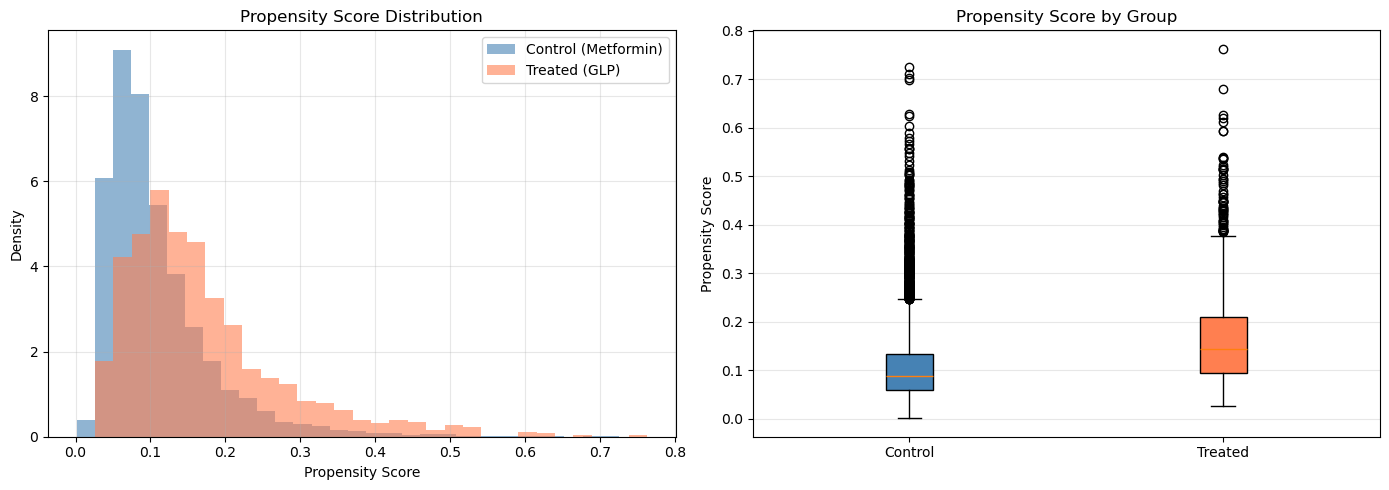

In [16]:
subset, covariate_names = calculate_propensity_scores(df, 'glp', 'metformin')
fig_ps = plot_propensity_scores(subset, 'glp')

## IPTW

In [17]:
# ============================================================================
# 3. IPTW WEIGHT CALCULATION (ATT)
# ============================================================================

def calculate_att_weights(df, truncate_percentiles=(0.5, 99.5)):
    """
    Calculate stabilized IPTW weights for ATT estimand with truncation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with treatment and propensity scores
    truncate_percentiles : tuple
        Lower and upper percentiles for weight truncation
        
    Returns:
    --------
    pd.DataFrame : Dataset with weights added
    """
    df = df.copy()
    
    # ATT weights:
    # Treated: w = 1
    # Control: w = PS / (1 - PS)
    df['weight_raw'] = np.where(
        df['treatment'] == 1,
        1,
        df['ps'] / (1 - df['ps'])
    )
    
    # Stabilization factor (prevalence of treatment)
    p_treat = df['treatment'].mean()
    
    # Stabilized weights:
    # Treated: w = 1
    # Control: w = p_treat * PS / (1 - PS)
    df['weight'] = np.where(
        df['treatment'] == 1,
        1,
        p_treat * df['ps'] / (1 - df['ps'])
    )
    
    # Truncate extreme weights
    lower, upper = np.percentile(df['weight'], truncate_percentiles)
    df['weight_truncated'] = df['weight'].clip(lower, upper)
    
    print(f"\nIPTW weights calculated (ATT estimand):")
    print(f"  Weight range before truncation: [{df['weight'].min():.4f}, {df['weight'].max():.4f}]")
    print(f"  Truncation at {truncate_percentiles}: [{lower:.4f}, {upper:.4f}]")
    print(f"  Weight range after truncation: [{df['weight_truncated'].min():.4f}, {df['weight_truncated'].max():.4f}]")
    print(f"  Effective sample size (treated): {df[df['treatment']==1]['weight_truncated'].sum():.1f}")
    print(f"  Effective sample size (control): {df[df['treatment']==0]['weight_truncated'].sum():.1f}")
    
    return df


def plot_weights(df, target_treatment):
    """
    Visualize weight distributions before and after truncation.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Control group weights before truncation
    control_weights = df[df['treatment']==0]['weight']
    axes[0, 0].hist(control_weights, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(control_weights.mean(), color='red', linestyle='--', 
                       label=f'Mean: {control_weights.mean():.2f}')
    axes[0, 0].set_xlabel('Weight')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Control Weights (Before Truncation)')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Control group weights after truncation
    control_weights_trunc = df[df['treatment']==0]['weight_truncated']
    axes[0, 1].hist(control_weights_trunc, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(control_weights_trunc.mean(), color='red', linestyle='--', 
                       label=f'Mean: {control_weights_trunc.mean():.2f}')
    axes[0, 1].set_xlabel('Weight')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Control Weights (After Truncation)')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Box plot comparison
    data_box = [
        df[df['treatment']==0]['weight'],
        df[df['treatment']==0]['weight_truncated']
    ]
    bp = axes[1, 0].boxplot(data_box, labels=['Before', 'After'], patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('steelblue')
    axes[1, 0].set_ylabel('Weight')
    axes[1, 0].set_title('Control Weights: Before vs After Truncation')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Summary statistics table
    axes[1, 1].axis('off')
    stats_data = [
        ['Metric', 'Before', 'After'],
        ['Mean', f"{control_weights.mean():.3f}", f"{control_weights_trunc.mean():.3f}"],
        ['Median', f"{control_weights.median():.3f}", f"{control_weights_trunc.median():.3f}"],
        ['Min', f"{control_weights.min():.3f}", f"{control_weights_trunc.min():.3f}"],
        ['Max', f"{control_weights.max():.3f}", f"{control_weights_trunc.max():.3f}"],
        ['SD', f"{control_weights.std():.3f}", f"{control_weights_trunc.std():.3f}"]
    ]
    table = axes[1, 1].table(cellText=stats_data, cellLoc='center', loc='center',
                             colWidths=[0.3, 0.35, 0.35])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    for i in range(len(stats_data[0])):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    axes[1, 1].set_title('Weight Statistics Summary', pad=20, fontweight='bold')
    
    plt.tight_layout()
    return fig



IPTW weights calculated (ATT estimand):
  Weight range before truncation: [0.0002, 1.0000]
  Truncation at (0.5, 99.5): [0.0029, 1.0000]
  Weight range after truncation: [0.0029, 1.0000]
  Effective sample size (treated): 1025.0
  Effective sample size (control): 120.0


/tmp/ipykernel_29043/1758250102.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(data_box, labels=['Before', 'After'], patch_artist=True)


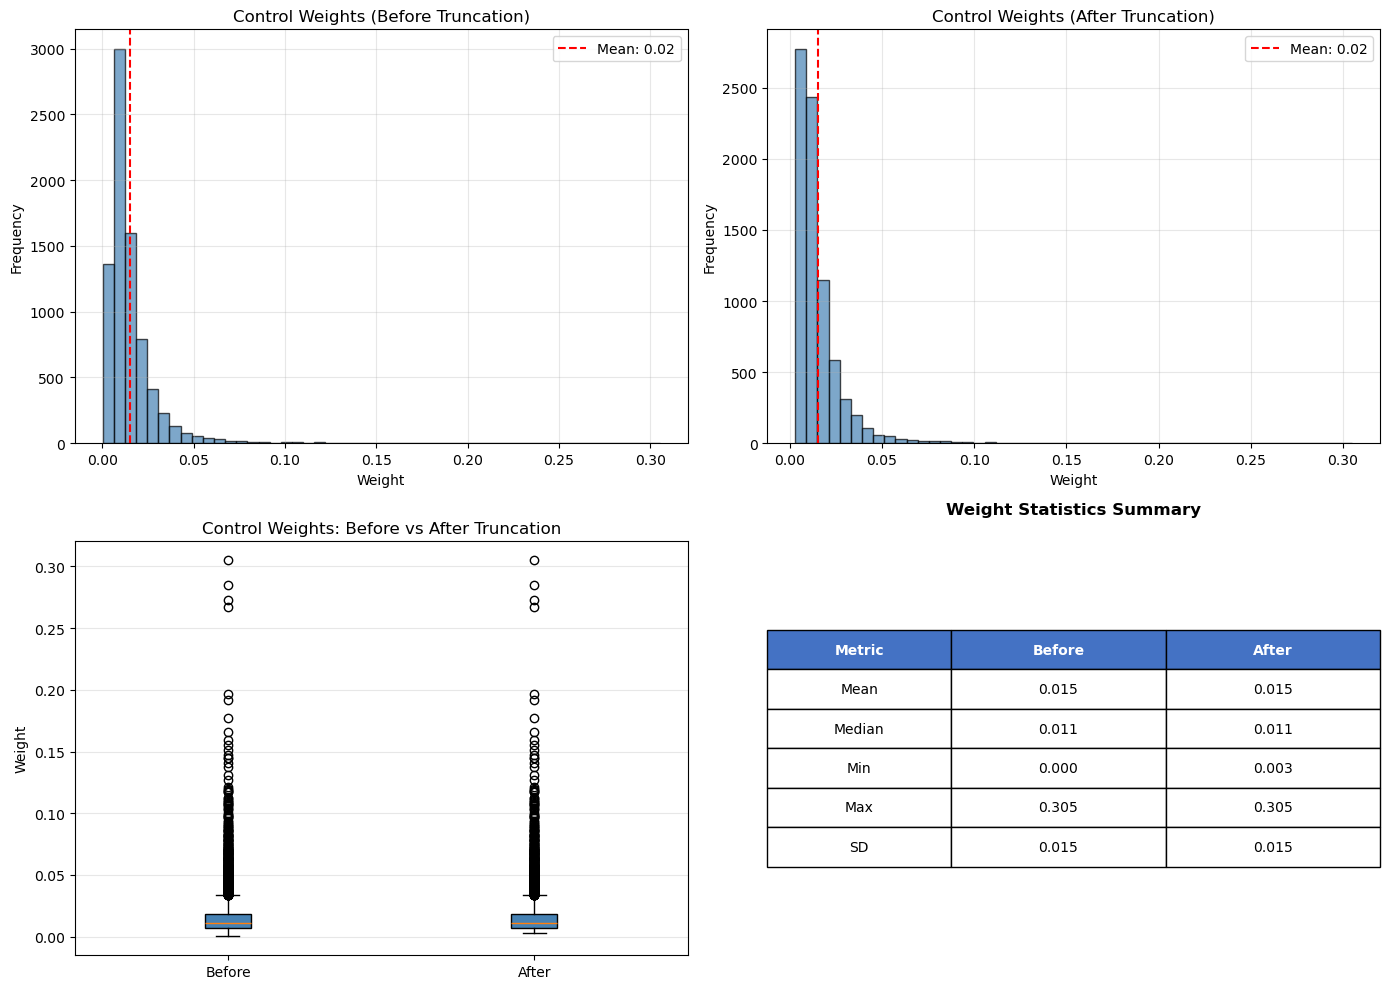

In [18]:
subset = calculate_att_weights(subset)
fig_weights = plot_weights(subset, 'glp')

## Balance diagnositics (SMD)

### - without balanced table

In [ ]:
# # ============================================================================
# # 4. BALANCE DIAGNOSTICS (SMD)
# # ============================================================================

# def calculate_smd(df, covariates, weight_col=None):
#     """
#     Calculate standardized mean differences for balance assessment.
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Dataset with treatment indicator
#     covariates : list
#         List of covariate column names
#     weight_col : str or None
#         Weight column name for weighted SMD (None for unweighted)
        
#     Returns:
#     --------
#     pd.DataFrame : SMD values for each covariate
#     """
#     treated = df[df['treatment'] == 1]
#     control = df[df['treatment'] == 0]
    
#     smd_values = []
    
#     for var in covariates:
#         if weight_col is None:
#             # Unweighted
#             mean_t = treated[var].mean()
#             mean_c = control[var].mean()
#             var_t = treated[var].var()
#             var_c = control[var].var()
#         else:
#             # Weighted
#             wt = treated[weight_col]
#             wc = control[weight_col]
#             mean_t = np.average(treated[var], weights=wt)
#             mean_c = np.average(control[var], weights=wc)
#             var_t = np.average((treated[var] - mean_t)**2, weights=wt)
#             var_c = np.average((control[var] - mean_c)**2, weights=wc)
        
#         pooled_sd = np.sqrt((var_t + var_c) / 2)
#         smd = (mean_t - mean_c) / pooled_sd if pooled_sd > 0 else 0
        
#         smd_values.append({
#             'covariate': var,
#             'smd': smd,
#             'abs_smd': abs(smd)
#         })
    
#     smd_df = pd.DataFrame(smd_values)
#     return smd_df


# def assess_balance(df, covariates=None, threshold=0.1):
#     """
#     Assess covariate balance before and after weighting.
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Dataset with weights
#     covariates : list or None
#         List of original covariate names (if None, uses default list)
#     threshold : float
#         SMD threshold for balance (default: 0.1)
        
#     Returns:
#     --------
#     pd.DataFrame : Balance diagnostics
#     """
#     # Use original covariates (before one-hot encoding)
#     if covariates is None:
#         covariates = [
#             'age_at_med', 'bmi', 'bmi_missing', 'ed', 'inpatient',
#             'outpatient', 'total_utilization', 'proteinuria', 'nausea', 
#             'gastroparesis', 'covid_dx_during', 'covid_trt_during', 
#             'vaccine_prior', 'a1c', 'a1c_missing', 'DPP4', 'Sulfonylurea', 
#             'Thiazolidinedione', 'insulin'
#         ]
        
#         # Add categorical variables (will handle specially)
#         categorical_vars = ['sex', 'race_ethnicity']
#     else:
#         # Filter to only original covariates that exist in df
#         covariates = [c for c in covariates if c in df.columns]
#         categorical_vars = []
    
#     # Calculate SMD for continuous/binary variables
#     smd_before = calculate_smd(df, covariates, weight_col=None)
#     smd_before.columns = ['covariate', 'smd_before', 'abs_smd_before']
    
#     smd_after = calculate_smd(df, covariates, weight_col='weight_truncated')
#     smd_after.columns = ['covariate', 'smd_after', 'abs_smd_after']
    
#     balance = pd.merge(smd_before, smd_after, on='covariate')
    
#     # Handle categorical variables separately
#     for cat_var in categorical_vars:
#         if cat_var in df.columns:
#             cat_smd_before = calculate_categorical_smd(df, cat_var, weight_col=None)
#             cat_smd_after = calculate_categorical_smd(df, cat_var, weight_col='weight_truncated')
            
#             cat_balance = pd.DataFrame({
#                 'covariate': [cat_var],
#                 'smd_before': [cat_smd_before],
#                 'abs_smd_before': [abs(cat_smd_before)],
#                 'smd_after': [cat_smd_after],
#                 'abs_smd_after': [abs(cat_smd_after)]
#             })
            
#             balance = pd.concat([balance, cat_balance], ignore_index=True)
    
#     balance['balanced'] = balance['abs_smd_after'] < threshold
    
#     print(f"\nBalance diagnostics (threshold: {threshold}):")
#     print(f"  Covariates balanced before weighting: {(balance['abs_smd_before'] < threshold).sum()}/{len(balance)}")
#     print(f"  Covariates balanced after weighting: {(balance['abs_smd_after'] < threshold).sum()}/{len(balance)}")
#     print(f"  Max absolute SMD before: {balance['abs_smd_before'].max():.4f}")
#     print(f"  Max absolute SMD after: {balance['abs_smd_after'].max():.4f}")
    
#     return balance


# def calculate_categorical_smd(df, var, weight_col=None):
#     """
#     Calculate SMD for categorical variables using the approach from
#     Yang & Dalton (2012) - takes the maximum SMD across all categories.
#     """
#     treated = df[df['treatment'] == 1]
#     control = df[df['treatment'] == 0]
    
#     categories = df[var].unique()
#     smds = []
    
#     for cat in categories:
#         # Create binary indicator for this category
#         treated_prop = (treated[var] == cat).astype(int)
#         control_prop = (control[var] == cat).astype(int)
        
#         if weight_col is None:
#             mean_t = treated_prop.mean()
#             mean_c = control_prop.mean()
#             var_t = treated_prop.var()
#             var_c = control_prop.var()
#         else:
#             wt = treated[weight_col]
#             wc = control[weight_col]
#             mean_t = np.average(treated_prop, weights=wt)
#             mean_c = np.average(control_prop, weights=wc)
#             var_t = np.average((treated_prop - mean_t)**2, weights=wt)
#             var_c = np.average((control_prop - mean_c)**2, weights=wc)
        
#         pooled_sd = np.sqrt((var_t + var_c) / 2)
#         smd = (mean_t - mean_c) / pooled_sd if pooled_sd > 0 else 0
#         smds.append(abs(smd))
    
#     # Return maximum absolute SMD across categories
#     return max(smds) if smds else 0

# def plot_balance(balance, threshold=0.1, target_treatment=''):
#     """
#     Create Love plot showing SMD before and after weighting.
#     """
#     fig, ax = plt.subplots(figsize=(10, max(8, len(balance) * 0.3)))
    
#     # Sort by before SMD
#     balance_sorted = balance.sort_values('abs_smd_before', ascending=True)
#     y_pos = np.arange(len(balance_sorted))
    
#     # Plot before and after
#     ax.scatter(balance_sorted['abs_smd_before'], y_pos, 
#               marker='o', s=80, color='coral', label='Before Weighting', alpha=0.7)
#     ax.scatter(balance_sorted['abs_smd_after'], y_pos, 
#               marker='s', s=80, color='steelblue', label='After Weighting', alpha=0.7)
    
#     # Connect with lines
#     for i, (before, after) in enumerate(zip(balance_sorted['abs_smd_before'], 
#                                             balance_sorted['abs_smd_after'])):
#         ax.plot([before, after], [i, i], 'k-', alpha=0.3, linewidth=0.8)
    
#     # Threshold line
#     ax.axvline(threshold, color='red', linestyle='--', linewidth=2, 
#               label=f'Balance Threshold ({threshold})')
    
#     # Formatting
#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(balance_sorted['covariate'], fontsize=9)
#     ax.set_xlabel('Absolute Standardized Mean Difference', fontsize=11, fontweight='bold')
#     ax.set_title(f'Covariate Balance: {target_treatment.upper()} vs Metformin', 
#                 fontsize=12, fontweight='bold', pad=15)
#     ax.legend(loc='best', fontsize=10)
#     ax.grid(alpha=0.3, axis='x')
#     ax.set_xlim(left=0)
    
#     plt.tight_layout()
#     return fig



### - with balanced table 

In [23]:
# ============================================================================
# 4. BALANCE DIAGNOSTICS (SMD)
# ============================================================================

def calculate_smd(df, covariates, weight_col=None):
    """
    Calculate standardized mean differences for balance assessment.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with treatment indicator
    covariates : list
        List of covariate column names
    weight_col : str or None
        Weight column name for weighted SMD (None for unweighted)
        
    Returns:
    --------
    pd.DataFrame : SMD values for each covariate
    """
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    
    smd_values = []
    
    for var in covariates:
        if weight_col is None:
            # Unweighted
            mean_t = treated[var].mean()
            mean_c = control[var].mean()
            var_t = treated[var].var()
            var_c = control[var].var()
        else:
            # Weighted
            wt = treated[weight_col]
            wc = control[weight_col]
            mean_t = np.average(treated[var], weights=wt)
            mean_c = np.average(control[var], weights=wc)
            var_t = np.average((treated[var] - mean_t)**2, weights=wt)
            var_c = np.average((control[var] - mean_c)**2, weights=wc)
        
        pooled_sd = np.sqrt((var_t + var_c) / 2)
        smd = (mean_t - mean_c) / pooled_sd if pooled_sd > 0 else 0
        
        smd_values.append({
            'covariate': var,
            'smd': smd,
            'abs_smd': abs(smd)
        })
    
    smd_df = pd.DataFrame(smd_values)
    return smd_df


def assess_balance(df, covariates=None, threshold=0.1):
    """
    Assess covariate balance before and after weighting.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with weights
    covariates : list or None
        List of original covariate names (if None, uses default list)
    threshold : float
        SMD threshold for balance (default: 0.1)
        
    Returns:
    --------
    pd.DataFrame : Balance diagnostics
    """
    # Use original covariates (before one-hot encoding)
    if covariates is None:
        covariates = [
            'age_at_med', 'bmi', 'bmi_missing', 'ed', 'inpatient',
            'outpatient', 'total_utilization', 'proteinuria', 'nausea', 
            'gastroparesis', 'covid_dx_during', 'covid_trt_during', 
            'vaccine_prior', 'a1c', 'a1c_missing', 'DPP4', 'Sulfonylurea', 
            'Thiazolidinedione', 'insulin'
        ]
        
        # Add categorical variables (will handle specially)
        categorical_vars = ['sex', 'race_ethnicity']
    else:
        # Filter to only original covariates that exist in df
        covariates = [c for c in covariates if c in df.columns]
        categorical_vars = []
    
    # Calculate SMD for continuous/binary variables
    smd_before = calculate_smd(df, covariates, weight_col=None)
    smd_before.columns = ['covariate', 'smd_before', 'abs_smd_before']
    
    smd_after = calculate_smd(df, covariates, weight_col='weight_truncated')
    smd_after.columns = ['covariate', 'smd_after', 'abs_smd_after']
    
    balance = pd.merge(smd_before, smd_after, on='covariate')
    
    # Handle categorical variables separately
    for cat_var in categorical_vars:
        if cat_var in df.columns:
            cat_smd_before = calculate_categorical_smd(df, cat_var, weight_col=None)
            cat_smd_after = calculate_categorical_smd(df, cat_var, weight_col='weight_truncated')
            
            cat_balance = pd.DataFrame({
                'covariate': [cat_var],
                'smd_before': [cat_smd_before],
                'abs_smd_before': [abs(cat_smd_before)],
                'smd_after': [cat_smd_after],
                'abs_smd_after': [abs(cat_smd_after)]
            })
            
            balance = pd.concat([balance, cat_balance], ignore_index=True)
    
    balance['balanced'] = balance['abs_smd_after'] < threshold
    
    print(f"\nBalance diagnostics (threshold: {threshold}):")
    print(f"  Covariates balanced before weighting: {(balance['abs_smd_before'] < threshold).sum()}/{len(balance)}")
    print(f"  Covariates balanced after weighting: {(balance['abs_smd_after'] < threshold).sum()}/{len(balance)}")
    print(f"  Max absolute SMD before: {balance['abs_smd_before'].max():.4f}")
    print(f"  Max absolute SMD after: {balance['abs_smd_after'].max():.4f}")
    
    return balance


def calculate_categorical_smd(df, var, weight_col=None):
    """
    Calculate SMD for categorical variables using the approach from
    Yang & Dalton (2012) - takes the maximum SMD across all categories.
    """
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    
    categories = df[var].unique()
    smds = []
    
    for cat in categories:
        # Create binary indicator for this category
        treated_prop = (treated[var] == cat).astype(int)
        control_prop = (control[var] == cat).astype(int)
        
        if weight_col is None:
            mean_t = treated_prop.mean()
            mean_c = control_prop.mean()
            var_t = treated_prop.var()
            var_c = control_prop.var()
        else:
            wt = treated[weight_col]
            wc = control[weight_col]
            mean_t = np.average(treated_prop, weights=wt)
            mean_c = np.average(control_prop, weights=wc)
            var_t = np.average((treated_prop - mean_t)**2, weights=wt)
            var_c = np.average((control_prop - mean_c)**2, weights=wc)
        
        pooled_sd = np.sqrt((var_t + var_c) / 2)
        smd = (mean_t - mean_c) / pooled_sd if pooled_sd > 0 else 0
        smds.append(abs(smd))
    
    # Return maximum absolute SMD across categories
    return max(smds) if smds else 0

def plot_balance(balance, threshold=0.1, target_treatment=''):
    """
    Create Love plot showing SMD before and after weighting, with full balance dataframe.
    """
    fig = plt.figure(figsize=(18, max(10, len(balance) * 0.4)))
    
    # Create grid: 55% for plot, 45% for table
    gs = fig.add_gridspec(1, 2, width_ratios=[5.5, 4.5], wspace=0.3)
    ax_plot = fig.add_subplot(gs[0])
    ax_table = fig.add_subplot(gs[1])
    
    # ===== LEFT: Love Plot =====
    balance_sorted = balance.sort_values('abs_smd_before', ascending=True)
    y_pos = np.arange(len(balance_sorted))
    
    # Plot before and after
    ax_plot.scatter(balance_sorted['abs_smd_before'], y_pos, 
                   marker='o', s=80, color='coral', label='Before Weighting', alpha=0.7)
    ax_plot.scatter(balance_sorted['abs_smd_after'], y_pos, 
                   marker='s', s=80, color='steelblue', label='After Weighting', alpha=0.7)
    
    # Connect with lines
    for i, (before, after) in enumerate(zip(balance_sorted['abs_smd_before'], 
                                            balance_sorted['abs_smd_after'])):
        ax_plot.plot([before, after], [i, i], 'k-', alpha=0.3, linewidth=0.8)
    
    # Threshold line
    ax_plot.axvline(threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Balance Threshold ({threshold})')
    
    # Formatting
    ax_plot.set_yticks(y_pos)
    ax_plot.set_yticklabels(balance_sorted['covariate'], fontsize=9)
    ax_plot.set_xlabel('Absolute Standardized Mean Difference', fontsize=11, fontweight='bold')
    ax_plot.set_title(f'Covariate Balance: {target_treatment.upper()} vs Metformin', 
                     fontsize=12, fontweight='bold', pad=15)
    ax_plot.legend(loc='best', fontsize=10)
    ax_plot.grid(alpha=0.3, axis='x')
    ax_plot.set_xlim(left=0)
    
    # ===== RIGHT: Balance DataFrame Table =====
    ax_table.axis('off')
    
    # Prepare table data - sort by abs_smd_after (descending) to show worst first
    balance_display = balance.sort_values('abs_smd_after', ascending=False).copy()
    
    # Round numeric columns for display
    balance_display['smd_before'] = balance_display['smd_before'].round(4)
    balance_display['abs_smd_before'] = balance_display['abs_smd_before'].round(4)
    balance_display['smd_after'] = balance_display['smd_after'].round(4)
    balance_display['abs_smd_after'] = balance_display['abs_smd_after'].round(4)
    balance_display['balanced'] = balance_display['balanced'].map({True: '✓', False: '✗'})
    
    # Shorten covariate names if too long
    balance_display['covariate'] = balance_display['covariate'].apply(
        lambda x: x[:25] + '...' if len(x) > 28 else x
    )
    
    # Select columns to display
    table_data = balance_display[['covariate', 'abs_smd_before', 'abs_smd_after', 'balanced']].values.tolist()
    
    # Add header
    table_data.insert(0, ['Covariate', '|SMD|\nBefore', '|SMD|\nAfter', 'Balanced'])
    
    # Create table
    table = ax_table.table(cellText=table_data, cellLoc='left', loc='center',
                          colWidths=[0.45, 0.18, 0.18, 0.12])
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    
    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white', ha='center')
    
    # Color code balanced column
    for i in range(1, len(table_data)):
        # Balanced column
        if table_data[i][3] == '✓':
            table[(i, 3)].set_facecolor('#C6EFCE')  # Light green
            table[(i, 3)].set_text_props(ha='center', color='green', weight='bold')
        else:
            table[(i, 3)].set_facecolor('#FFC7CE')  # Light red
            table[(i, 3)].set_text_props(ha='center', color='red', weight='bold')
        
        # Highlight high SMD values after weighting
        smd_after = float(table_data[i][2])
        if smd_after >= 0.1:
            table[(i, 2)].set_facecolor('#FFF2CC')  # Light yellow warning
            table[(i, 2)].set_text_props(weight='bold')
    
    ax_table.set_title('Balance Table', fontsize=12, fontweight='bold', pad=15)
    
    # Add summary text
    n_balanced = (balance['abs_smd_after'] < threshold).sum()
    n_total = len(balance)
    summary_text = f"Summary: {n_balanced}/{n_total} covariates balanced (|SMD| < {threshold})"
    fig.text(0.77, 0.02, summary_text, ha='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig


Balance diagnostics (threshold: 0.1):
  Covariates balanced before weighting: 8/19
  Covariates balanced after weighting: 19/19
  Max absolute SMD before: 0.3924
  Max absolute SMD after: 0.0402


/tmp/ipykernel_29043/2595125451.py:263: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


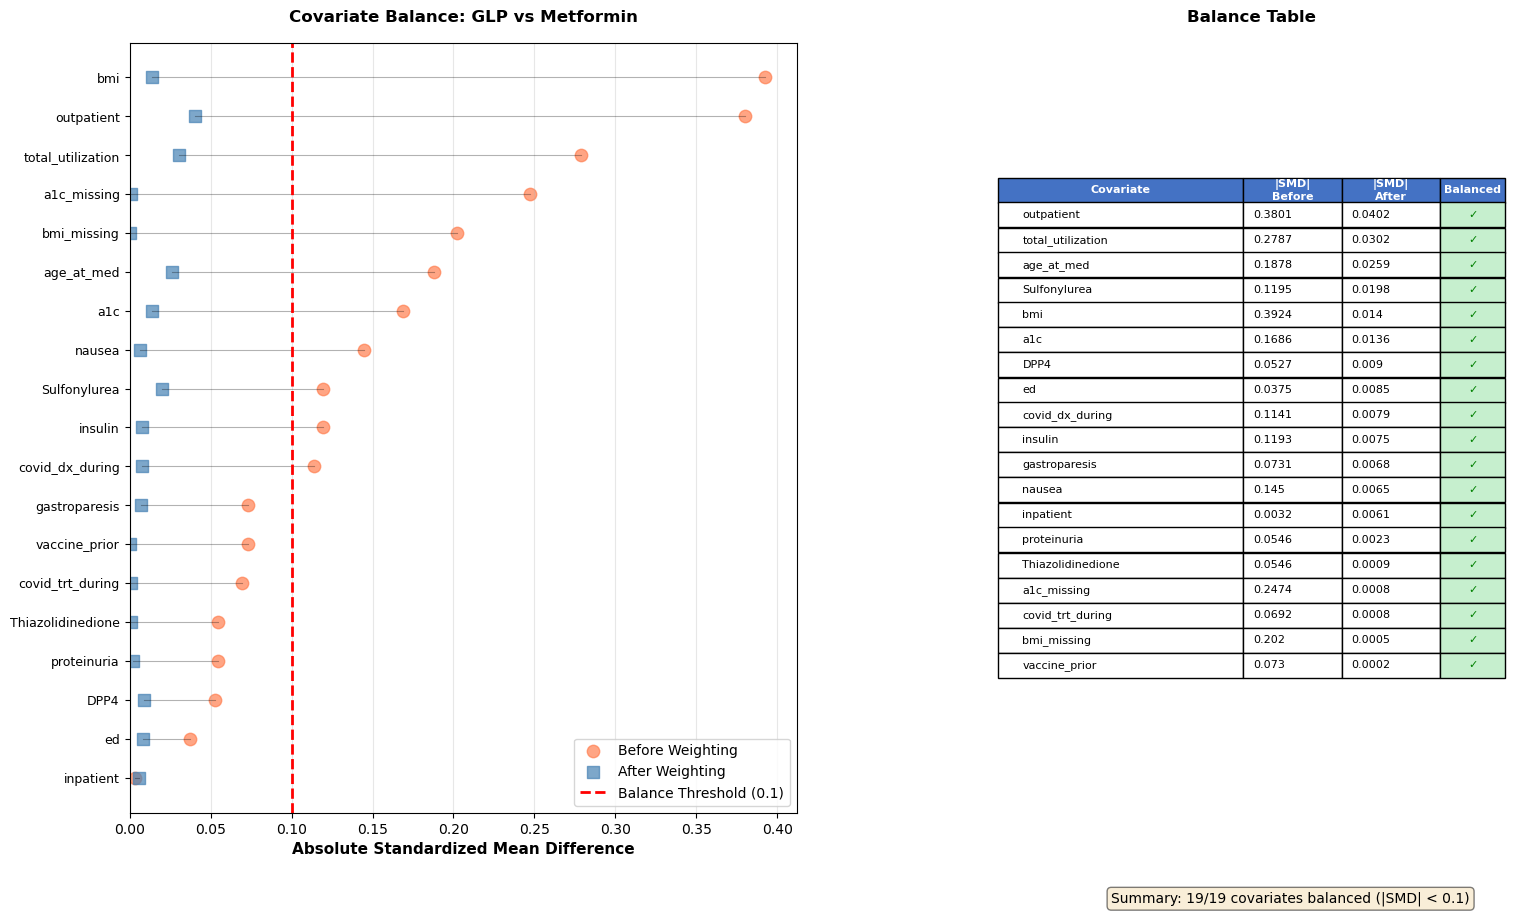

In [24]:
balance = assess_balance(subset, covariate_names)
fig_balance = plot_balance(balance, threshold=0.1, target_treatment='glp')

## Survival analysis

In [44]:
def estimate_cumulative_incidence(df, time_points=None):
    """
    Estimate cumulative incidence curves using Aalen-Johansen estimator.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with time, event, treatment, and weights
    time_points : array-like or None
        Time points for evaluation (default: None, uses observed times)
        
    Returns:
    --------
    dict : Cumulative incidence estimates by treatment group
    """
    if time_points is None:
        time_points = np.linspace(0, 180, 181)
    
    results = {}
    
    for treat in [0, 1]:
        subset = df[df['treatment'] == treat].copy()
        
        # Aalen-Johansen for competing risks
        aj = AalenJohansenFitter(calculate_variance=True)
        aj.fit(
            durations=subset['time'],
            event_observed=subset['event'],
            event_of_interest=1,  # PASC is event of interest
            weights=subset['weight_truncated']
        )
        
        # Extract cumulative incidence curve for PASC (event=1)
        ci_curve = aj.cumulative_density_
        
        # Get the column name for event of interest (usually first column or named '1')
        # The columns represent different event types
        event_col = ci_curve.columns[0]  # First column is event of interest
        
        # Extract CI at 180 days
        if 180 in ci_curve.index:
            ci_at_180 = ci_curve.loc[180, event_col]
        else:
            # If 180 is not exact, find closest time <= 180
            times_up_to_180 = ci_curve.index[ci_curve.index <= 180]
            if len(times_up_to_180) > 0:
                ci_at_180 = ci_curve.loc[times_up_to_180[-1], event_col]
            else:
                ci_at_180 = 0.0
        
        results[treat] = {
            'aj_model': aj,
            'ci_curve': ci_curve,
            'event_col': event_col,
            'ci_at_180': ci_at_180
        }
    
    print(f"\nCumulative incidence at 180 days:")
    print(f"  Treated: {results[1]['ci_at_180']:.4f}")
    print(f"  Control: {results[0]['ci_at_180']:.4f}")
    print(f"  Risk difference: {results[1]['ci_at_180'] - results[0]['ci_at_180']:.4f}")
    
    return results

def plot_cumulative_incidence(ci_results, target_treatment):
    """
    Plot cumulative incidence curves for both groups.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Extract curves and column names
    control_curve = ci_results[0]['ci_curve']
    treated_curve = ci_results[1]['ci_curve']
    control_col = ci_results[0]['event_col']
    treated_col = ci_results[1]['event_col']
    
    # Plot control
    ax.step(control_curve.index, control_curve[control_col], 
           where='post', color='steelblue', linewidth=2.5, 
           label='Control (Metformin)', alpha=0.8)
    
    # Plot treated
    ax.step(treated_curve.index, treated_curve[treated_col], 
           where='post', color='coral', linewidth=2.5, 
           label=f'Treated ({target_treatment.upper()})', alpha=0.8)

    # Add confidence bands if available
    try:
        ci_results[0]['aj_model'].plot_cumulative_density(ci_show=True, ax=ax)
        ci_results[1]['aj_model'].plot_cumulative_density(ci_show=True, ax=ax)
    except:
        pass
    
    # Mark 180-day estimates
    ci_180_control = ci_results[0]['ci_at_180']
    ci_180_treated = ci_results[1]['ci_at_180']
    
    ax.plot(180, ci_180_control, 'o', color='steelblue', markersize=10, 
           markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    ax.plot(180, ci_180_treated, 'o', color='coral', markersize=10, 
           markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    
    # Add text annotations
    ax.text(180, ci_180_control, f'  {ci_180_control:.3f}', 
           verticalalignment='center', fontsize=10, fontweight='bold')
    ax.text(180, ci_180_treated, f'  {ci_180_treated:.3f}', 
           verticalalignment='center', fontsize=10, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Days from Index Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Incidence of PASC', fontsize=12, fontweight='bold')
    ax.set_title(f'Cumulative Incidence of PASC: {target_treatment.upper()} vs Metformin\n(Accounting for Death as Competing Risk)', 
                fontsize=13, fontweight='bold', pad=15)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 180)
    
    # Determine y-axis limit dynamically
    max_ci = max(ci_180_control, ci_180_treated)
    ax.set_ylim(0, max_ci * 1.2 if max_ci > 0 else 0.1)
    
    # Add risk difference annotation
    risk_diff = ci_180_treated - ci_180_control
    textstr = f'Risk Difference at 180 days:\n{risk_diff:.4f} ({risk_diff*100:.2f}%)'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=11,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    return fig

/opt/conda/lib/python3.12/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. 


Cumulative incidence at 180 days:
  Treated: 0.3424
  Control: 0.3451
  Risk difference: -0.0027


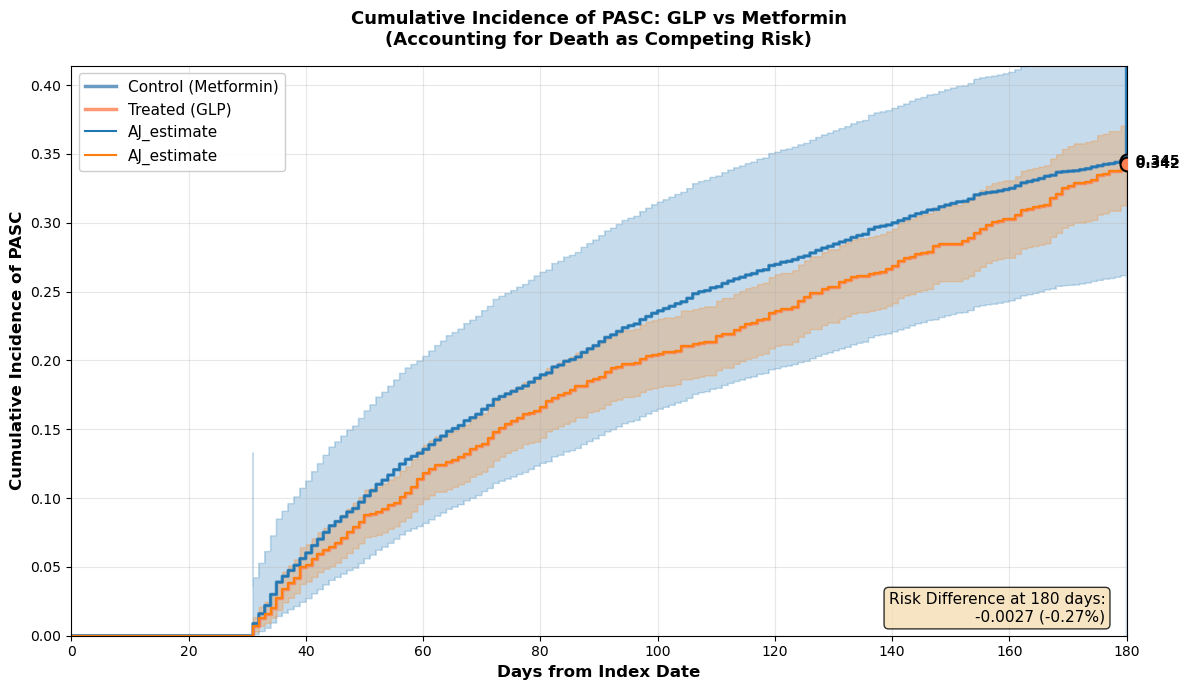

In [45]:
ci_results = estimate_cumulative_incidence(subset)
fig_ci = plot_cumulative_incidence(ci_results, 'glp')

## COX hazards

In [46]:
# ============================================================================
# 6. COX PROPORTIONAL HAZARDS MODEL
# ============================================================================

def fit_cox_model(df):
    """
    Fit weighted Cox proportional hazards model.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with time, event, treatment, and weights
        
    Returns:
    --------
    CoxPHFitter : Fitted Cox model
    """
    # Prepare data for Cox model (exclude competing risks)
    cox_data = df[df['event'].isin([0, 1])].copy()
    cox_data['event_pasc'] = (cox_data['event'] == 1).astype(int)
    
    # Fit weighted Cox model
    cph = CoxPHFitter()
    cph.fit(
        cox_data[['time', 'event_pasc', 'treatment', 'weight_truncated']],
        duration_col='time',
        event_col='event_pasc',
        weights_col='weight_truncated',
        robust=True  # Robust variance estimator
    )
    
    hr = np.exp(cph.params_['treatment'])
    ci_lower = np.exp(cph.confidence_intervals_['95% lower-bound']['treatment'])
    ci_upper = np.exp(cph.confidence_intervals_['95% upper-bound']['treatment'])
    p_value = cph.summary['p']['treatment']
    
    print(f"\nCox proportional hazards model:")
    print(f"  Hazard ratio: {hr:.3f} (95% CI: [{ci_lower:.3f}, {ci_upper:.3f}])")
    print(f"  P-value: {p_value:.4f}")
    
    return cph


def plot_cox_results(cox_model, target_treatment):
    """
    Plot hazard ratio with confidence interval.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    
    hr = np.exp(cox_model.params_['treatment'])
    ci_lower = np.exp(cox_model.confidence_intervals_['95% lower-bound']['treatment'])
    ci_upper = np.exp(cox_model.confidence_intervals_['95% upper-bound']['treatment'])
    p_value = cox_model.summary['p']['treatment']
    
    # Forest plot style
    ax.plot([ci_lower, ci_upper], [0, 0], 'k-', linewidth=2)
    ax.plot(hr, 0, 'D', color='coral', markersize=12, 
           markeredgecolor='black', markeredgewidth=1.5)
    
    # Null line
    ax.axvline(1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='HR = 1 (No Effect)')
    
    # Annotations
    ax.text(hr, 0.15, f'HR = {hr:.3f}\n95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]\np = {p_value:.4f}',
           horizontalalignment='center', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Formatting
    ax.set_xlabel('Hazard Ratio', fontsize=12, fontweight='bold')
    ax.set_title(f'Hazard Ratio for PASC: {target_treatment.upper()} vs Metformin', 
                fontsize=13, fontweight='bold', pad=15)
    ax.set_yticks([])
    ax.set_ylim(-0.5, 0.5)
    ax.grid(alpha=0.3, axis='x')
    ax.legend(loc='upper right', fontsize=10)
    
    # Add interpretation text
    interpretation = "Favors Treated" if hr < 1 else "Favors Control"
    side = "left" if hr < 1 else "right"
    ax.text(0.02 if hr < 1 else 0.98, -0.35, interpretation,
           transform=ax.transAxes, fontsize=11, fontweight='bold',
           horizontalalignment='left' if hr < 1 else 'right',
           color='green' if hr < 1 else 'darkred')
    
    plt.tight_layout()
    return fig


Cox proportional hazards model:
  Hazard ratio: 0.954 (95% CI: [0.849, 1.073])
  P-value: 0.4340


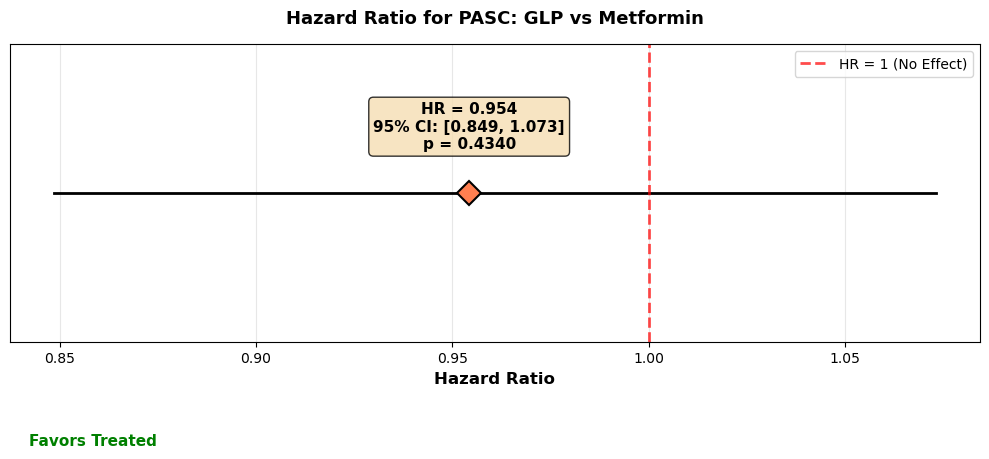

In [47]:
cox_model = fit_cox_model(subset)
fig_cox = plot_cox_results(cox_model, 'glp')

## Bootstrap confidence intervals

In [50]:
# ============================================================================
# 7. BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================

def bootstrap_risk_estimates(df, n_iterations=1000, random_state=42):
    """
    Bootstrap confidence intervals for absolute risks and risk differences.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with time, event, treatment, and weights
    n_iterations : int
        Number of bootstrap iterations
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Bootstrap estimates and confidence intervals
    """
    np.random.seed(random_state)
    
    risk_treated = []
    risk_control = []
    risk_diff = []
    
    print(f"\nRunning bootstrap with {n_iterations} iterations...")
    
    for i in range(n_iterations):
        # Bootstrap sample with replacement
        boot_sample = df.sample(n=len(df), replace=True, random_state=random_state+i)
        
        # Recalculate weights for bootstrap sample
        boot_sample = calculate_att_weights(boot_sample, truncate_percentiles=(0.5, 99.5))
        
        # Estimate cumulative incidence at 180 days
        try:
            ci_results = estimate_cumulative_incidence(boot_sample)
            risk_treated.append(ci_results[1]['ci_at_180'])
            risk_control.append(ci_results[0]['ci_at_180'])
            risk_diff.append(ci_results[1]['ci_at_180'] - ci_results[0]['ci_at_180'])
        except:
            continue
        
        if (i + 1) % 100 == 0:
            print(f"  Bootstrap iteration {i+1}/{n_iterations} complete")
    
    results = {
        'risk_treated_mean': np.mean(risk_treated),
        'risk_treated_ci': (np.percentile(risk_treated, 2.5), np.percentile(risk_treated, 97.5)),
        'risk_control_mean': np.mean(risk_control),
        'risk_control_ci': (np.percentile(risk_control, 2.5), np.percentile(risk_control, 97.5)),
        'risk_diff_mean': np.mean(risk_diff),
        'risk_diff_ci': (np.percentile(risk_diff, 2.5), np.percentile(risk_diff, 97.5)),
        'distributions': {
            'risk_treated': risk_treated,
            'risk_control': risk_control,
            'risk_diff': risk_diff
        }
    }
    
    print(f"\nBootstrap results ({len(risk_treated)} successful iterations):")
    print(f"  Risk (treated): {results['risk_treated_mean']:.4f} "
          f"(95% CI: [{results['risk_treated_ci'][0]:.4f}, {results['risk_treated_ci'][1]:.4f}])")
    print(f"  Risk (control): {results['risk_control_mean']:.4f} "
          f"(95% CI: [{results['risk_control_ci'][0]:.4f}, {results['risk_control_ci'][1]:.4f}])")
    print(f"  Risk difference: {results['risk_diff_mean']:.4f} "
          f"(95% CI: [{results['risk_diff_ci'][0]:.4f}, {results['risk_diff_ci'][1]:.4f}])")
    
    return results


def plot_bootstrap_distributions(boot_results, target_treatment):
    """
    Visualize bootstrap distributions of risk estimates.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    risk_treated = boot_results['distributions']['risk_treated']
    risk_control = boot_results['distributions']['risk_control']
    risk_diff = boot_results['distributions']['risk_diff']
    
    # Treated risk distribution
    axes[0].hist(risk_treated, bins=40, color='coral', alpha=0.7, edgecolor='black')
    axes[0].axvline(boot_results['risk_treated_mean'], color='red', 
                   linestyle='--', linewidth=2, label='Mean')
    axes[0].axvline(boot_results['risk_treated_ci'][0], color='darkred', 
                   linestyle=':', linewidth=2, label='95% CI')
    axes[0].axvline(boot_results['risk_treated_ci'][1], color='darkred', 
                   linestyle=':', linewidth=2)
    axes[0].set_xlabel('Risk at 180 Days', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title(f'Bootstrap: Treated ({target_treatment.upper()}) Risk', 
                     fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Control risk distribution
    axes[1].hist(risk_control, bins=40, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].axvline(boot_results['risk_control_mean'], color='red', 
                   linestyle='--', linewidth=2, label='Mean')
    axes[1].axvline(boot_results['risk_control_ci'][0], color='darkred', 
                   linestyle=':', linewidth=2, label='95% CI')
    axes[1].axvline(boot_results['risk_control_ci'][1], color='darkred', 
                   linestyle=':', linewidth=2)
    axes[1].set_xlabel('Risk at 180 Days', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('Bootstrap: Control (Metformin) Risk', 
                     fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Risk difference distribution
    axes[2].hist(risk_diff, bins=40, color='purple', alpha=0.7, edgecolor='black')
    axes[2].axvline(boot_results['risk_diff_mean'], color='red', 
                   linestyle='--', linewidth=2, label='Mean')
    axes[2].axvline(boot_results['risk_diff_ci'][0], color='darkred', 
                   linestyle=':', linewidth=2, label='95% CI')
    axes[2].axvline(boot_results['risk_diff_ci'][1], color='darkred', 
                   linestyle=':', linewidth=2)
    axes[2].axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    axes[2].set_xlabel('Risk Difference at 180 Days', fontsize=11, fontweight='bold')
    axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[2].set_title('Bootstrap: Risk Difference', 
                     fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


In [52]:
# boot_results = None
# fig_bootstrap = None
# if run_bootstrap:
#     boot_results = bootstrap_risk_estimates(subset, n_iterations=1000)
#     fig_bootstrap = plot_bootstrap_distributions(boot_results, target_treatment)

In [54]:
# boot_results = bootstrap_risk_estimates(subset, n_iterations=1000)
# fig_bootstrap = plot_bootstrap_distributions(boot_results, 'glp')

In [55]:
def create_summary_table(df, balance, ci_results, cox_model, boot_results=None, target_treatment=''):
    """
    Create comprehensive summary table of key results.
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis('off')
    
    # Build summary data
    summary_data = [
        ['METRIC', 'VALUE'],
        ['', ''],
        ['SAMPLE SIZES', ''],
        ['Total patients', f"{len(df):,}"],
        ['Treated group', f"{(df['treatment']==1).sum():,}"],
        ['Control group', f"{(df['treatment']==0).sum():,}"],
        ['PASC events (total)', f"{(df['event']==1).sum():,}"],
        ['Death events (total)', f"{(df['event']==2).sum():,}"],
        ['', ''],
        ['BALANCE DIAGNOSTICS', ''],
        ['Covariates assessed', f"{len(balance)}"],
        ['Balanced before weighting', f"{(balance['abs_smd_before'] < 0.1).sum()}/{len(balance)}"],
        ['Balanced after weighting', f"{(balance['abs_smd_after'] < 0.1).sum()}/{len(balance)}"],
        ['Max |SMD| before', f"{balance['abs_smd_before'].max():.4f}"],
        ['Max |SMD| after', f"{balance['abs_smd_after'].max():.4f}"],
        ['', ''],
        ['CUMULATIVE INCIDENCE AT 180 DAYS', ''],
        [f'Treated ({target_treatment.upper()})', f"{ci_results[1]['ci_at_180']:.4f} ({ci_results[1]['ci_at_180']*100:.2f}%)"],
        ['Control (Metformin)', f"{ci_results[0]['ci_at_180']:.4f} ({ci_results[0]['ci_at_180']*100:.2f}%)"],
        ['Absolute Risk Difference', f"{ci_results[1]['ci_at_180'] - ci_results[0]['ci_at_180']:.4f}"],
        ['', ''],
        ['COX MODEL RESULTS', ''],
        ['Hazard Ratio', f"{np.exp(cox_model.params_['treatment']):.3f}"],
        ['95% CI (lower)', f"{np.exp(cox_model.confidence_intervals_['95% lower-bound']['treatment']):.3f}"],
        ['95% CI (upper)', f"{np.exp(cox_model.confidence_intervals_['95% upper-bound']['treatment']):.3f}"],
        ['P-value', f"{cox_model.summary['p']['treatment']:.4f}"]
    ]
    
    if boot_results is not None:
        summary_data.extend([
            ['', ''],
            ['BOOTSTRAP RESULTS (1000 iterations)', ''],
            ['Risk Treated (mean)', f"{boot_results['risk_treated_mean']:.4f}"],
            ['Risk Treated (95% CI)', f"[{boot_results['risk_treated_ci'][0]:.4f}, {boot_results['risk_treated_ci'][1]:.4f}]"],
            ['Risk Control (mean)', f"{boot_results['risk_control_mean']:.4f}"],
            ['Risk Control (95% CI)', f"[{boot_results['risk_control_ci'][0]:.4f}, {boot_results['risk_control_ci'][1]:.4f}]"],
            ['Risk Difference (mean)', f"{boot_results['risk_diff_mean']:.4f}"],
            ['Risk Difference (95% CI)', f"[{boot_results['risk_diff_ci'][0]:.4f}, {boot_results['risk_diff_ci'][1]:.4f}]"]
        ])
    
    # Create table
    table = ax.table(cellText=summary_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)
    
    # Style header
    for i in range(len(summary_data[0])):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Style section headers
    section_rows = [2, 9, 16, 21]
    if boot_results is not None:
        section_rows.append(26)
    
    for row in section_rows:
        table[(row, 0)].set_facecolor('#B4C7E7')
        table[(row, 0)].set_text_props(weight='bold')
        table[(row, 1)].set_facecolor('#B4C7E7')
    
    ax.set_title(f'Analysis Summary: {target_treatment.upper()} vs Metformin for PASC Prevention', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


ANALYSIS COMPLETE: GLP vs METFORMIN



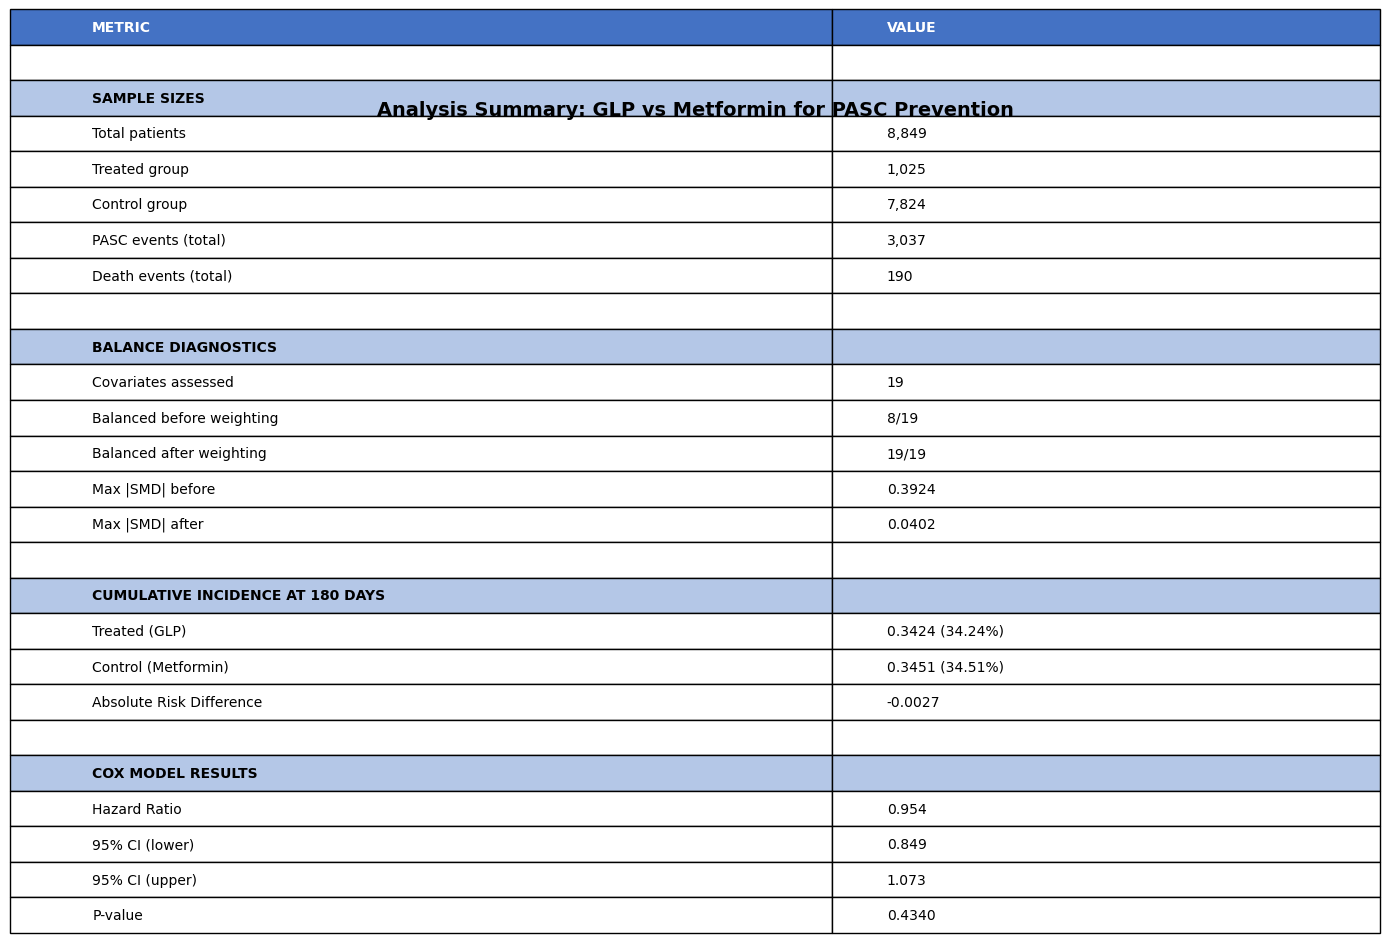

In [63]:
fig_summary = create_summary_table(subset, balance, ci_results, cox_model, 
                                      boot_results, 'glp')
    
results = {
        'data': subset,
        'balance': balance,
        'cumulative_incidence': ci_results,
        'cox_model': cox_model,
        'bootstrap': boot_results,
        'figures': {
            'propensity_scores': fig_ps,
            'weights': fig_weights,
            'balance': fig_balance,
            'cumulative_incidence': fig_ci,
            'cox': fig_cox,
            'bootstrap': fig_bootstrap,
            'summary': fig_summary
        }
    }
    
print(f"\n{'='*80}")
print(f"ANALYSIS COMPLETE: GLP vs METFORMIN")
print(f"{'='*80}\n")

## FULL PIPELINE

In [45]:
"""
Target Trial Emulation Analysis Pipeline
Comparing SGLT2 and GLP1 vs Metformin for PASC outcomes
"""

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter, AalenJohansenFitter
from lifelines.utils import survival_table_from_events
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# ============================================================================
# 1. DATA PREPARATION
# ============================================================================

def prepare_data(df):
    """
    Prepare dataset for analysis: create time-to-event variables and handle missing data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw dataset with all columns
        
    Returns:
    --------
    pd.DataFrame : Prepared dataset with computed time-to-event variables
    """
    df = df.copy()
    
    # Outcome date columns
    outcome_cols = [
        'Diseases of the Blood and Blood Forming Organs and Certain Disorders Involving the Immune Mechanism (first date)',
        'Diseases of the Circulatory System (first date)',
        'Diseases of the Digestive System (first date)',
        'Diseases of the Musculoskeletal System and Connective Tissue (first date)',
        'Diseases of the Nervous System (first date)',
        'Diseases of the Respiratory System (first date)',
        'Diseases of the Skin and Subcutaneous Tissue (first date)',
        'Endocrine, Nutritional and Metabolic Diseases (first date)',
        'General (first date)'
    ]
    
    # Convert dates to datetime
    df['index_date'] = pd.to_datetime(df['index_date'])
    df['death_date'] = pd.to_datetime(df['death_date'])
    for col in outcome_cols:
        df[col] = pd.to_datetime(df[col])
    
    # Find earliest PASC event date across all outcome columns
    df['pasc_date'] = df[outcome_cols].min(axis=1)
    
    # Calculate time to PASC event (in days)
    df['time_to_pasc'] = (df['pasc_date'] - df['index_date']).dt.days
    
    # Calculate time to death (in days)
    df['time_to_death'] = (df['death_date'] - df['index_date']).dt.days
    
    # Determine event type and time
    # Event codes: 0=censored, 1=PASC, 2=death
    df['event'] = 0
    df['time'] = 180  # Default censoring at 180 days
    
    # PASC occurred
    pasc_mask = df['time_to_pasc'].notna() & (df['time_to_pasc'] <= 180)
    df.loc[pasc_mask, 'event'] = 1
    df.loc[pasc_mask, 'time'] = df.loc[pasc_mask, 'time_to_pasc']
    
    # Death occurred (competing risk)
    death_mask = df['time_to_death'].notna() & (df['time_to_death'] <= 180)
    # If both PASC and death, take whichever came first
    both_mask = pasc_mask & death_mask
    death_first = both_mask & (df['time_to_death'] < df['time_to_pasc'])
    death_only = death_mask & ~pasc_mask
    
    df.loc[death_first | death_only, 'event'] = 2
    df.loc[death_first | death_only, 'time'] = df.loc[death_first | death_only, 'time_to_death']
    
    # Handle missing BMI: convert string 'missing' or 'na' to NaN
    df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')
    df['bmi_missing'] = df['bmi'].isna().astype(int)
    bmi_median = df['bmi'].median()
    df['bmi'] = df['bmi'].fillna(bmi_median)
    
    # Handle missing A1C: create indicator and median impute
    df['a1c_missing'] = df['a1c'].isna().astype(int)
    a1c_median = df['a1c'].median()
    df['a1c'] = df['a1c'].fillna(a1c_median)
    
    print(f"Data preparation complete:")
    print(f"  Total patients: {len(df)}")
    print(f"  PASC events: {(df['event'] == 1).sum()}")
    print(f"  Death events: {(df['event'] == 2).sum()}")
    print(f"  Censored: {(df['event'] == 0).sum()}")
    print(f"  BMI missing indicator created (median imputed: {bmi_median:.2f})")
    print(f"  A1C missing indicator created (median imputed: {a1c_median:.2f})")
    
    return df


# ============================================================================
# 2. PROPENSITY SCORE ESTIMATION
# ============================================================================

def calculate_propensity_scores(df, target_treatment, comparison='metformin'):
    """
    Calculate propensity scores using L2-regularized logistic regression.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Prepared dataset
    target_treatment : str
        Target treatment group ('sglt2' or 'glp1')
    comparison : str
        Comparison group (default: 'metformin')
        
    Returns:
    --------
    pd.DataFrame : Subset with propensity scores added
    """
    # Covariates for propensity score model
    covariates = [
        'age_at_med', 'sex', 'race_ethnicity', 'bmi', 'bmi_missing', 'ed', 'inpatient',
        'outpatient', 'total_utilization', 'proteinuria', 'nausea', 'gastroparesis',
        'covid_dx_during', 'covid_trt_during', 'vaccine_prior', 'a1c', 'a1c_missing',
        'DPP4', 'Sulfonylurea', 'Thiazolidinedione', 'insulin'
    ]
    
    # Subset to comparison groups
    subset = df[df['cohort'].isin([comparison, target_treatment])].copy()
    
    # Create treatment indicator (1=target, 0=comparison)
    subset['treatment'] = (subset['cohort'] == target_treatment).astype(int)
    
    # Prepare covariates - handle categorical variables
    X = subset[covariates].copy()
    
    # One-hot encode categorical variables
    X = pd.get_dummies(X, columns=['sex', 'race_ethnicity'], drop_first=True)
    
    # Standardize continuous variables for regularization
    continuous_vars = ['age_at_med', 'bmi', 'total_utilization', 'a1c']
    scaler = StandardScaler()
    X[continuous_vars] = scaler.fit_transform(X[continuous_vars])
    
    # Fit L2-regularized logistic regression
    ps_model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
    ps_model.fit(X, subset['treatment'])
    
    # Calculate propensity scores
    subset['ps'] = ps_model.predict_proba(X)[:, 1]
    
    print(f"\nPropensity scores calculated for {target_treatment} vs {comparison}:")
    print(f"  PS range: [{subset['ps'].min():.4f}, {subset['ps'].max():.4f}]")
    print(f"  Mean PS (treated): {subset[subset['treatment']==1]['ps'].mean():.4f}")
    print(f"  Mean PS (control): {subset[subset['treatment']==0]['ps'].mean():.4f}")
    
    return subset, X.columns.tolist()


def plot_propensity_scores(df, target_treatment):
    """
    Visualize propensity score distributions by treatment group.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(df[df['treatment']==0]['ps'], bins=30, alpha=0.6, 
                 label='Control (Metformin)', color='steelblue', density=True)
    axes[0].hist(df[df['treatment']==1]['ps'], bins=30, alpha=0.6, 
                 label=f'Treated ({target_treatment.upper()})', color='coral', density=True)
    axes[0].set_xlabel('Propensity Score')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Propensity Score Distribution')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot
    data_box = [df[df['treatment']==0]['ps'], df[df['treatment']==1]['ps']]
    bp = axes[1].boxplot(data_box, labels=['Control', 'Treated'], patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('coral')
    axes[1].set_ylabel('Propensity Score')
    axes[1].set_title('Propensity Score by Group')
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig


# ============================================================================
# 3. IPTW WEIGHT CALCULATION (ATT)
# ============================================================================

def calculate_att_weights(df, truncate_percentiles=(0.5, 99.5)):
    """
    Calculate stabilized IPTW weights for ATT estimand with truncation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with treatment and propensity scores
    truncate_percentiles : tuple
        Lower and upper percentiles for weight truncation
        
    Returns:
    --------
    pd.DataFrame : Dataset with weights added
    """
    df = df.copy()
    
    # ATT weights:
    # Treated: w = 1
    # Control: w = PS / (1 - PS)
    df['weight_raw'] = np.where(
        df['treatment'] == 1,
        1,
        df['ps'] / (1 - df['ps'])
    )
    
    # Stabilization factor (prevalence of treatment)
    p_treat = df['treatment'].mean()
    
    # Stabilized weights:
    # Treated: w = 1
    # Control: w = p_treat * PS / (1 - PS)
    df['weight'] = np.where(
        df['treatment'] == 1,
        1,
        p_treat * df['ps'] / (1 - df['ps'])
    )
    
    # Truncate extreme weights
    lower, upper = np.percentile(df['weight'], truncate_percentiles)
    df['weight_truncated'] = df['weight'].clip(lower, upper)
    
    print(f"\nIPTW weights calculated (ATT estimand):")
    print(f"  Weight range before truncation: [{df['weight'].min():.4f}, {df['weight'].max():.4f}]")
    print(f"  Truncation at {truncate_percentiles}: [{lower:.4f}, {upper:.4f}]")
    print(f"  Weight range after truncation: [{df['weight_truncated'].min():.4f}, {df['weight_truncated'].max():.4f}]")
    print(f"  Effective sample size (treated): {df[df['treatment']==1]['weight_truncated'].sum():.1f}")
    print(f"  Effective sample size (control): {df[df['treatment']==0]['weight_truncated'].sum():.1f}")
    
    return df


def plot_weights(df, target_treatment):
    """
    Visualize weight distributions before and after truncation.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Control group weights before truncation
    control_weights = df[df['treatment']==0]['weight']
    axes[0, 0].hist(control_weights, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(control_weights.mean(), color='red', linestyle='--', 
                       label=f'Mean: {control_weights.mean():.2f}')
    axes[0, 0].set_xlabel('Weight')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Control Weights (Before Truncation)')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Control group weights after truncation
    control_weights_trunc = df[df['treatment']==0]['weight_truncated']
    axes[0, 1].hist(control_weights_trunc, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(control_weights_trunc.mean(), color='red', linestyle='--', 
                       label=f'Mean: {control_weights_trunc.mean():.2f}')
    axes[0, 1].set_xlabel('Weight')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Control Weights (After Truncation)')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Box plot comparison
    data_box = [
        df[df['treatment']==0]['weight'],
        df[df['treatment']==0]['weight_truncated']
    ]
    bp = axes[1, 0].boxplot(data_box, labels=['Before', 'After'], patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('steelblue')
    axes[1, 0].set_ylabel('Weight')
    axes[1, 0].set_title('Control Weights: Before vs After Truncation')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Summary statistics table
    axes[1, 1].axis('off')
    stats_data = [
        ['Metric', 'Before', 'After'],
        ['Mean', f"{control_weights.mean():.3f}", f"{control_weights_trunc.mean():.3f}"],
        ['Median', f"{control_weights.median():.3f}", f"{control_weights_trunc.median():.3f}"],
        ['Min', f"{control_weights.min():.3f}", f"{control_weights_trunc.min():.3f}"],
        ['Max', f"{control_weights.max():.3f}", f"{control_weights_trunc.max():.3f}"],
        ['SD', f"{control_weights.std():.3f}", f"{control_weights_trunc.std():.3f}"]
    ]
    table = axes[1, 1].table(cellText=stats_data, cellLoc='center', loc='center',
                             colWidths=[0.3, 0.35, 0.35])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    for i in range(len(stats_data[0])):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    axes[1, 1].set_title('Weight Statistics Summary', pad=20, fontweight='bold')
    
    plt.tight_layout()
    return fig


# ============================================================================
# 4. BALANCE DIAGNOSTICS (SMD)
# ============================================================================

def calculate_smd(df, covariates, weight_col=None):
    """
    Calculate standardized mean differences for balance assessment.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with treatment indicator
    covariates : list
        List of covariate column names
    weight_col : str or None
        Weight column name for weighted SMD (None for unweighted)
        
    Returns:
    --------
    pd.DataFrame : SMD values for each covariate
    """
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    
    smd_values = []
    
    for var in covariates:
        if weight_col is None:
            # Unweighted
            mean_t = treated[var].mean()
            mean_c = control[var].mean()
            var_t = treated[var].var()
            var_c = control[var].var()
        else:
            # Weighted
            wt = treated[weight_col]
            wc = control[weight_col]
            mean_t = np.average(treated[var], weights=wt)
            mean_c = np.average(control[var], weights=wc)
            var_t = np.average((treated[var] - mean_t)**2, weights=wt)
            var_c = np.average((control[var] - mean_c)**2, weights=wc)
        
        pooled_sd = np.sqrt((var_t + var_c) / 2)
        smd = (mean_t - mean_c) / pooled_sd if pooled_sd > 0 else 0
        
        smd_values.append({
            'covariate': var,
            'smd': smd,
            'abs_smd': abs(smd)
        })
    
    smd_df = pd.DataFrame(smd_values)
    return smd_df


def assess_balance(df, covariates, threshold=0.1):
    """
    Assess covariate balance before and after weighting.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with weights
    covariates : list
        List of covariate names
    threshold : float
        SMD threshold for balance (default: 0.1)
        
    Returns:
    --------
    pd.DataFrame : Balance diagnostics
    """
    # Before weighting
    smd_before = calculate_smd(df, covariates, weight_col=None)
    smd_before.columns = ['covariate', 'smd_before', 'abs_smd_before']
    
    # After weighting
    smd_after = calculate_smd(df, covariates, weight_col='weight_truncated')
    smd_after.columns = ['covariate', 'smd_after', 'abs_smd_after']
    
    # Combine
    balance = pd.merge(smd_before, smd_after, on='covariate')
    balance['balanced'] = balance['abs_smd_after'] < threshold
    
    print(f"\nBalance diagnostics (threshold: {threshold}):")
    print(f"  Covariates balanced before weighting: {(balance['abs_smd_before'] < threshold).sum()}/{len(balance)}")
    print(f"  Covariates balanced after weighting: {(balance['abs_smd_after'] < threshold).sum()}/{len(balance)}")
    print(f"  Max absolute SMD before: {balance['abs_smd_before'].max():.4f}")
    print(f"  Max absolute SMD after: {balance['abs_smd_after'].max():.4f}")
    
    return balance


def plot_balance(balance, threshold=0.1, target_treatment=''):
    """
    Create Love plot showing SMD before and after weighting.
    """
    fig, ax = plt.subplots(figsize=(10, max(8, len(balance) * 0.3)))
    
    # Sort by before SMD
    balance_sorted = balance.sort_values('abs_smd_before', ascending=True)
    y_pos = np.arange(len(balance_sorted))
    
    # Plot before and after
    ax.scatter(balance_sorted['abs_smd_before'], y_pos, 
              marker='o', s=80, color='coral', label='Before Weighting', alpha=0.7)
    ax.scatter(balance_sorted['abs_smd_after'], y_pos, 
              marker='s', s=80, color='steelblue', label='After Weighting', alpha=0.7)
    
    # Connect with lines
    for i, (before, after) in enumerate(zip(balance_sorted['abs_smd_before'], 
                                            balance_sorted['abs_smd_after'])):
        ax.plot([before, after], [i, i], 'k-', alpha=0.3, linewidth=0.8)
    
    # Threshold line
    ax.axvline(threshold, color='red', linestyle='--', linewidth=2, 
              label=f'Balance Threshold ({threshold})')
    
    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels(balance_sorted['covariate'], fontsize=9)
    ax.set_xlabel('Absolute Standardized Mean Difference', fontsize=11, fontweight='bold')
    ax.set_title(f'Covariate Balance: {target_treatment.upper()} vs Metformin', 
                fontsize=12, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3, axis='x')
    ax.set_xlim(left=0)
    
    plt.tight_layout()
    return fig


# ============================================================================
# 5. SURVIVAL ANALYSIS - CUMULATIVE INCIDENCE (AALEN-JOHANSEN)
# ============================================================================

def estimate_cumulative_incidence(df, time_points=None):
    """
    Estimate cumulative incidence curves using Aalen-Johansen estimator.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with time, event, treatment, and weights
    time_points : array-like or None
        Time points for evaluation (default: None, uses observed times)
        
    Returns:
    --------
    dict : Cumulative incidence estimates by treatment group
    """
    if time_points is None:
        time_points = np.linspace(0, 180, 181)
    
    results = {}
    
    for treat in [0, 1]:
        subset = df[df['treatment'] == treat].copy()
        
        # Aalen-Johansen for competing risks
        aj = AalenJohansenFitter(calculate_variance=True)
        aj.fit(
            durations=subset['time'],
            event_observed=subset['event'],
            event_of_interest=1,  # PASC is event of interest
            weights=subset['weight_truncated']
        )
        
        # Extract cumulative incidence at specified time points
        ci_curve = aj.cumulative_density_
        
        results[treat] = {
            'aj_model': aj,
            'ci_curve': ci_curve,
            'ci_at_180': ci_curve.loc[180, 1] if 180 in ci_curve.index else ci_curve.iloc[-1, 0]
        }
    
    print(f"\nCumulative incidence at 180 days:")
    print(f"  Treated: {results[1]['ci_at_180']:.4f}")
    print(f"  Control: {results[0]['ci_at_180']:.4f}")
    print(f"  Risk difference: {results[1]['ci_at_180'] - results[0]['ci_at_180']:.4f}")
    
    return results


def plot_cumulative_incidence(ci_results, target_treatment):
    """
    Plot cumulative incidence curves for both groups.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Extract curves
    control_curve = ci_results[0]['ci_curve']
    treated_curve = ci_results[1]['ci_curve']
    
    # Plot control
    ax.step(control_curve.index, control_curve.iloc[:, 0], 
           where='post', color='steelblue', linewidth=2.5, 
           label='Control (Metformin)', alpha=0.8)
    
    # Plot treated
    ax.step(treated_curve.index, treated_curve.iloc[:, 0], 
           where='post', color='coral', linewidth=2.5, 
           label=f'Treated ({target_treatment.upper()})', alpha=0.8)
    
    # Add confidence bands if available
    try:
        ci_results[0]['aj_model'].plot_cumulative_density(ci_show=True, ax=ax)
        ci_results[1]['aj_model'].plot_cumulative_density(ci_show=True, ax=ax)
    except:
        pass
    
    # Mark 180-day estimates
    ci_180_control = ci_results[0]['ci_at_180']
    ci_180_treated = ci_results[1]['ci_at_180']
    
    ax.plot(180, ci_180_control, 'o', color='steelblue', markersize=10, 
           markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    ax.plot(180, ci_180_treated, 'o', color='coral', markersize=10, 
           markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    
    # Add text annotations
    ax.text(180, ci_180_control, f'  {ci_180_control:.3f}', 
           verticalalignment='center', fontsize=10, fontweight='bold')
    ax.text(180, ci_180_treated, f'  {ci_180_treated:.3f}', 
           verticalalignment='center', fontsize=10, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Days from Index Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Incidence of PASC', fontsize=12, fontweight='bold')
    ax.set_title(f'Cumulative Incidence of PASC: {target_treatment.upper()} vs Metformin\n(Accounting for Death as Competing Risk)', 
                fontsize=13, fontweight='bold', pad=15)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 180)
    ax.set_ylim(0, max(ci_180_control, ci_180_treated) * 1.2)
    
    # Add risk difference annotation
    risk_diff = ci_180_treated - ci_180_control
    textstr = f'Risk Difference at 180 days:\n{risk_diff:.4f} ({risk_diff*100:.2f}%)'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=11,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    return fig


# ============================================================================
# 6. COX PROPORTIONAL HAZARDS MODEL
# ============================================================================

def fit_cox_model(df):
    """
    Fit weighted Cox proportional hazards model.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with time, event, treatment, and weights
        
    Returns:
    --------
    CoxPHFitter : Fitted Cox model
    """
    # Prepare data for Cox model (exclude competing risks)
    cox_data = df[df['event'].isin([0, 1])].copy()
    cox_data['event_pasc'] = (cox_data['event'] == 1).astype(int)
    
    # Fit weighted Cox model
    cph = CoxPHFitter()
    cph.fit(
        cox_data[['time', 'event_pasc', 'treatment', 'weight_truncated']],
        duration_col='time',
        event_col='event_pasc',
        weights_col='weight_truncated',
        robust=True  # Robust variance estimator
    )
    
    hr = np.exp(cph.params_['treatment'])
    ci_lower = np.exp(cph.confidence_intervals_['95% lower-bound']['treatment'])
    ci_upper = np.exp(cph.confidence_intervals_['95% upper-bound']['treatment'])
    p_value = cph.summary['p']['treatment']
    
    print(f"\nCox proportional hazards model:")
    print(f"  Hazard ratio: {hr:.3f} (95% CI: [{ci_lower:.3f}, {ci_upper:.3f}])")
    print(f"  P-value: {p_value:.4f}")
    
    return cph


def plot_cox_results(cox_model, target_treatment):
    """
    Plot hazard ratio with confidence interval.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    
    hr = np.exp(cox_model.params_['treatment'])
    ci_lower = np.exp(cox_model.confidence_intervals_['95% lower-bound']['treatment'])
    ci_upper = np.exp(cox_model.confidence_intervals_['95% upper-bound']['treatment'])
    p_value = cox_model.summary['p']['treatment']
    
    # Forest plot style
    ax.plot([ci_lower, ci_upper], [0, 0], 'k-', linewidth=2)
    ax.plot(hr, 0, 'D', color='coral', markersize=12, 
           markeredgecolor='black', markeredgewidth=1.5)
    
    # Null line
    ax.axvline(1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='HR = 1 (No Effect)')
    
    # Annotations
    ax.text(hr, 0.15, f'HR = {hr:.3f}\n95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]\np = {p_value:.4f}',
           horizontalalignment='center', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Formatting
    ax.set_xlabel('Hazard Ratio', fontsize=12, fontweight='bold')
    ax.set_title(f'Hazard Ratio for PASC: {target_treatment.upper()} vs Metformin', 
                fontsize=13, fontweight='bold', pad=15)
    ax.set_yticks([])
    ax.set_ylim(-0.5, 0.5)
    ax.grid(alpha=0.3, axis='x')
    ax.legend(loc='upper right', fontsize=10)
    
    # Add interpretation text
    interpretation = "Favors Treated" if hr < 1 else "Favors Control"
    side = "left" if hr < 1 else "right"
    ax.text(0.02 if hr < 1 else 0.98, -0.35, interpretation,
           transform=ax.transAxes, fontsize=11, fontweight='bold',
           horizontalalignment='left' if hr < 1 else 'right',
           color='green' if hr < 1 else 'darkred')
    
    plt.tight_layout()
    return fig


# ============================================================================
# 7. BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================

def bootstrap_risk_estimates(df, n_iterations=1000, random_state=42):
    """
    Bootstrap confidence intervals for absolute risks and risk differences.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with time, event, treatment, and weights
    n_iterations : int
        Number of bootstrap iterations
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Bootstrap estimates and confidence intervals
    """
    np.random.seed(random_state)
    
    risk_treated = []
    risk_control = []
    risk_diff = []
    
    print(f"\nRunning bootstrap with {n_iterations} iterations...")
    
    for i in range(n_iterations):
        # Bootstrap sample with replacement
        boot_sample = df.sample(n=len(df), replace=True, random_state=random_state+i)
        
        # Recalculate weights for bootstrap sample
        boot_sample = calculate_att_weights(boot_sample, truncate_percentiles=(0.5, 99.5))
        
        # Estimate cumulative incidence at 180 days
        try:
            ci_results = estimate_cumulative_incidence(boot_sample)
            risk_treated.append(ci_results[1]['ci_at_180'])
            risk_control.append(ci_results[0]['ci_at_180'])
            risk_diff.append(ci_results[1]['ci_at_180'] - ci_results[0]['ci_at_180'])
        except:
            continue
        
        if (i + 1) % 100 == 0:
            print(f"  Bootstrap iteration {i+1}/{n_iterations} complete")
    
    results = {
        'risk_treated_mean': np.mean(risk_treated),
        'risk_treated_ci': (np.percentile(risk_treated, 2.5), np.percentile(risk_treated, 97.5)),
        'risk_control_mean': np.mean(risk_control),
        'risk_control_ci': (np.percentile(risk_control, 2.5), np.percentile(risk_control, 97.5)),
        'risk_diff_mean': np.mean(risk_diff),
        'risk_diff_ci': (np.percentile(risk_diff, 2.5), np.percentile(risk_diff, 97.5)),
        'distributions': {
            'risk_treated': risk_treated,
            'risk_control': risk_control,
            'risk_diff': risk_diff
        }
    }
    
    print(f"\nBootstrap results ({len(risk_treated)} successful iterations):")
    print(f"  Risk (treated): {results['risk_treated_mean']:.4f} "
          f"(95% CI: [{results['risk_treated_ci'][0]:.4f}, {results['risk_treated_ci'][1]:.4f}])")
    print(f"  Risk (control): {results['risk_control_mean']:.4f} "
          f"(95% CI: [{results['risk_control_ci'][0]:.4f}, {results['risk_control_ci'][1]:.4f}])")
    print(f"  Risk difference: {results['risk_diff_mean']:.4f} "
          f"(95% CI: [{results['risk_diff_ci'][0]:.4f}, {results['risk_diff_ci'][1]:.4f}])")
    
    return results


def plot_bootstrap_distributions(boot_results, target_treatment):
    """
    Visualize bootstrap distributions of risk estimates.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    risk_treated = boot_results['distributions']['risk_treated']
    risk_control = boot_results['distributions']['risk_control']
    risk_diff = boot_results['distributions']['risk_diff']
    
    # Treated risk distribution
    axes[0].hist(risk_treated, bins=40, color='coral', alpha=0.7, edgecolor='black')
    axes[0].axvline(boot_results['risk_treated_mean'], color='red', 
                   linestyle='--', linewidth=2, label='Mean')
    axes[0].axvline(boot_results['risk_treated_ci'][0], color='darkred', 
                   linestyle=':', linewidth=2, label='95% CI')
    axes[0].axvline(boot_results['risk_treated_ci'][1], color='darkred', 
                   linestyle=':', linewidth=2)
    axes[0].set_xlabel('Risk at 180 Days', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title(f'Bootstrap: Treated ({target_treatment.upper()}) Risk', 
                     fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Control risk distribution
    axes[1].hist(risk_control, bins=40, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].axvline(boot_results['risk_control_mean'], color='red', 
                   linestyle='--', linewidth=2, label='Mean')
    axes[1].axvline(boot_results['risk_control_ci'][0], color='darkred', 
                   linestyle=':', linewidth=2, label='95% CI')
    axes[1].axvline(boot_results['risk_control_ci'][1], color='darkred', 
                   linestyle=':', linewidth=2)
    axes[1].set_xlabel('Risk at 180 Days', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('Bootstrap: Control (Metformin) Risk', 
                     fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Risk difference distribution
    axes[2].hist(risk_diff, bins=40, color='purple', alpha=0.7, edgecolor='black')
    axes[2].axvline(boot_results['risk_diff_mean'], color='red', 
                   linestyle='--', linewidth=2, label='Mean')
    axes[2].axvline(boot_results['risk_diff_ci'][0], color='darkred', 
                   linestyle=':', linewidth=2, label='95% CI')
    axes[2].axvline(boot_results['risk_diff_ci'][1], color='darkred', 
                   linestyle=':', linewidth=2)
    axes[2].axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    axes[2].set_xlabel('Risk Difference at 180 Days', fontsize=11, fontweight='bold')
    axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[2].set_title('Bootstrap: Risk Difference', 
                     fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


# ============================================================================
# 8. COMPREHENSIVE SUMMARY VISUALIZATION
# ============================================================================

def create_summary_table(df, balance, ci_results, cox_model, boot_results=None, target_treatment=''):
    """
    Create comprehensive summary table of key results.
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis('off')
    
    # Build summary data
    summary_data = [
        ['METRIC', 'VALUE'],
        ['', ''],
        ['SAMPLE SIZES', ''],
        ['Total patients', f"{len(df):,}"],
        ['Treated group', f"{(df['treatment']==1).sum():,}"],
        ['Control group', f"{(df['treatment']==0).sum():,}"],
        ['PASC events (total)', f"{(df['event']==1).sum():,}"],
        ['Death events (total)', f"{(df['event']==2).sum():,}"],
        ['', ''],
        ['BALANCE DIAGNOSTICS', ''],
        ['Covariates assessed', f"{len(balance)}"],
        ['Balanced before weighting', f"{(balance['abs_smd_before'] < 0.1).sum()}/{len(balance)}"],
        ['Balanced after weighting', f"{(balance['abs_smd_after'] < 0.1).sum()}/{len(balance)}"],
        ['Max |SMD| before', f"{balance['abs_smd_before'].max():.4f}"],
        ['Max |SMD| after', f"{balance['abs_smd_after'].max():.4f}"],
        ['', ''],
        ['CUMULATIVE INCIDENCE AT 180 DAYS', ''],
        [f'Treated ({target_treatment.upper()})', f"{ci_results[1]['ci_at_180']:.4f} ({ci_results[1]['ci_at_180']*100:.2f}%)"],
        ['Control (Metformin)', f"{ci_results[0]['ci_at_180']:.4f} ({ci_results[0]['ci_at_180']*100:.2f}%)"],
        ['Absolute Risk Difference', f"{ci_results[1]['ci_at_180'] - ci_results[0]['ci_at_180']:.4f}"],
        ['', ''],
        ['COX MODEL RESULTS', ''],
        ['Hazard Ratio', f"{np.exp(cox_model.params_['treatment']):.3f}"],
        ['95% CI (lower)', f"{np.exp(cox_model.confidence_intervals_['95% lower-bound']['treatment']):.3f}"],
        ['95% CI (upper)', f"{np.exp(cox_model.confidence_intervals_['95% upper-bound']['treatment']):.3f}"],
        ['P-value', f"{cox_model.summary['p']['treatment']:.4f}"]
    ]
    
    if boot_results is not None:
        summary_data.extend([
            ['', ''],
            ['BOOTSTRAP RESULTS (1000 iterations)', ''],
            ['Risk Treated (mean)', f"{boot_results['risk_treated_mean']:.4f}"],
            ['Risk Treated (95% CI)', f"[{boot_results['risk_treated_ci'][0]:.4f}, {boot_results['risk_treated_ci'][1]:.4f}]"],
            ['Risk Control (mean)', f"{boot_results['risk_control_mean']:.4f}"],
            ['Risk Control (95% CI)', f"[{boot_results['risk_control_ci'][0]:.4f}, {boot_results['risk_control_ci'][1]:.4f}]"],
            ['Risk Difference (mean)', f"{boot_results['risk_diff_mean']:.4f}"],
            ['Risk Difference (95% CI)', f"[{boot_results['risk_diff_ci'][0]:.4f}, {boot_results['risk_diff_ci'][1]:.4f}]"]
        ])
    
    # Create table
    table = ax.table(cellText=summary_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)
    
    # Style header
    for i in range(len(summary_data[0])):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Style section headers
    section_rows = [2, 9, 16, 21]
    if boot_results is not None:
        section_rows.append(26)
    
    for row in section_rows:
        table[(row, 0)].set_facecolor('#B4C7E7')
        table[(row, 0)].set_text_props(weight='bold')
        table[(row, 1)].set_facecolor('#B4C7E7')
    
    ax.set_title(f'Analysis Summary: {target_treatment.upper()} vs Metformin for PASC Prevention', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


# ============================================================================
# 9. MAIN ANALYSIS PIPELINE
# ============================================================================

def run_analysis(df, target_treatment, comparison='metformin', run_bootstrap=False):
    """
    Run complete analysis pipeline for one comparison.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw dataset
    target_treatment : str
        Target treatment ('sglt2' or 'glp1')
    comparison : str
        Comparison group ('metformin')
    run_bootstrap : bool
        Whether to run bootstrap (slow, default: False)
        
    Returns:
    --------
    dict : All analysis results and figures
    """
    print(f"\n{'='*80}")
    print(f"ANALYSIS: {target_treatment.upper()} vs {comparison.upper()}")
    print(f"{'='*80}")
    
    # 1. Data preparation (only once if not already done)
    if 'time' not in df.columns:
        df = prepare_data(df)
    
    # 2. Calculate propensity scores
    subset, covariate_names = calculate_propensity_scores(df, target_treatment, comparison)
    fig_ps = plot_propensity_scores(subset, target_treatment)
    
    # 3. Calculate IPTW weights
    subset = calculate_att_weights(subset)
    fig_weights = plot_weights(subset, target_treatment)
    
    # 4. Assess balance
    balance = assess_balance(subset, covariate_names)
    fig_balance = plot_balance(balance, threshold=0.1, target_treatment=target_treatment)
    
    # 5. Cumulative incidence estimation
    ci_results = estimate_cumulative_incidence(subset)
    fig_ci = plot_cumulative_incidence(ci_results, target_treatment)
    
    # 6. Cox model
    cox_model = fit_cox_model(subset)
    fig_cox = plot_cox_results(cox_model, target_treatment)
    
    # 7. Bootstrap confidence intervals (optional - can be slow)
    boot_results = None
    fig_bootstrap = None
    if run_bootstrap:
        boot_results = bootstrap_risk_estimates(subset, n_iterations=1000)
        fig_bootstrap = plot_bootstrap_distributions(boot_results, target_treatment)
    
    # 8. Summary table
    fig_summary = create_summary_table(subset, balance, ci_results, cox_model, 
                                      boot_results, target_treatment)
    
    results = {
        'data': subset,
        'balance': balance,
        'cumulative_incidence': ci_results,
        'cox_model': cox_model,
        'bootstrap': boot_results,
        'figures': {
            'propensity_scores': fig_ps,
            'weights': fig_weights,
            'balance': fig_balance,
            'cumulative_incidence': fig_ci,
            'cox': fig_cox,
            'bootstrap': fig_bootstrap,
            'summary': fig_summary
        }
    }
    
    print(f"\n{'='*80}")
    print(f"ANALYSIS COMPLETE: {target_treatment.upper()} vs {comparison.upper()}")
    print(f"{'='*80}\n")
    
    return results


def save_all_results(results, output_dir, target_treatment):
    """
    Save all results including data, figures, and tables.
    
    Parameters:
    -----------
    results : dict
        Results from run_analysis()
    output_dir : str
        Directory to save outputs
    target_treatment : str
        Treatment name for file naming
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    prefix = f"{target_treatment}_vs_metformin"
    
    # Save data
    results['data'].to_csv(f"{output_dir}/{prefix}_data.csv", index=False)
    results['balance'].to_csv(f"{output_dir}/{prefix}_balance.csv", index=False)
    
    # Save figures
    for name, fig in results['figures'].items():
        if fig is not None:
            fig.savefig(f"{output_dir}/{prefix}_{name}.png", dpi=300, bbox_inches='tight')
            plt.close(fig)
    
    # Save Cox summary
    results['cox_model'].summary.to_csv(f"{output_dir}/{prefix}_cox_summary.csv")
    
    # Save bootstrap if available
    if results['bootstrap'] is not None:
        boot_df = pd.DataFrame({
            'metric': ['risk_treated', 'risk_control', 'risk_difference'],
            'mean': [results['bootstrap']['risk_treated_mean'],
                    results['bootstrap']['risk_control_mean'],
                    results['bootstrap']['risk_diff_mean']],
            'ci_lower': [results['bootstrap']['risk_treated_ci'][0],
                        results['bootstrap']['risk_control_ci'][0],
                        results['bootstrap']['risk_diff_ci'][0]],
            'ci_upper': [results['bootstrap']['risk_treated_ci'][1],
                        results['bootstrap']['risk_control_ci'][1],
                        results['bootstrap']['risk_diff_ci'][1]]
        })
        boot_df.to_csv(f"{output_dir}/{prefix}_bootstrap.csv", index=False)
    
    print(f"\nAll results saved to: {output_dir}")


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Load your data
    # df = pd.read_csv('your_data.csv')
    
    # Run analysis for SGLT2 vs Metformin
    # results_sglt2 = run_analysis(df, target_treatment='sglt2', run_bootstrap=False)
    
    # Run analysis for GLP1 vs Metformin  
    # results_glp1 = run_analysis(df, target_treatment='glp1', run_bootstrap=False)
    
    # Save results
    # save_all_results(results_sglt2, output_dir='./results_sglt2', target_treatment='sglt2')
    # save_all_results(results_glp1, output_dir='./results_glp1', target_treatment='glp1')
    
    # Display specific figures
    # results_sglt2['figures']['balance'].show()
    # results_sglt2['figures']['cumulative_incidence'].show()
    
    pass


ANALYSIS: SGLT2 vs METFORMIN
Data preparation complete:
  Total patients: 10204
  PASC events: 3517
  Death events: 248
  Censored: 6439
  BMI missing indicator created (median imputed: 32.00)
  A1C missing indicator created (median imputed: 7.00)

Propensity scores calculated for sglt2 vs metformin:
  PS range: [0.0245, 0.8782]
  Mean PS (treated): 0.1828
  Mean PS (control): 0.1416

IPTW weights calculated (ATT estimand):
  Weight range before truncation: [0.0037, 1.0646]
  Truncation at (0.5, 99.5): [0.0059, 1.0000]
  Weight range after truncation: [0.0059, 1.0000]
  Effective sample size (treated): 1355.0
  Effective sample size (control): 201.8


KeyError: 'sex_Male'

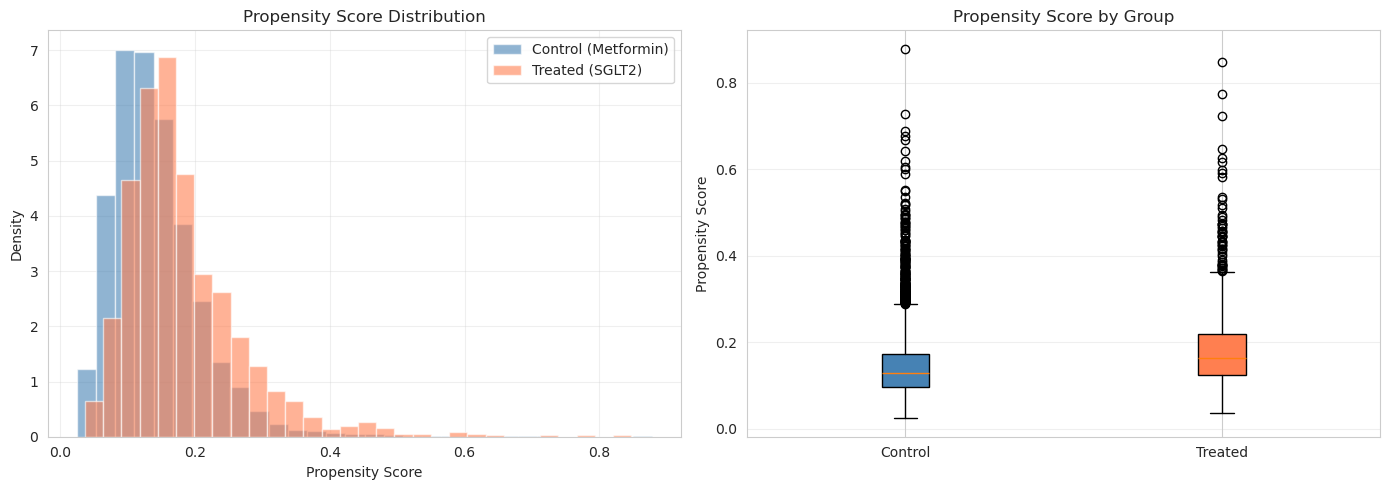

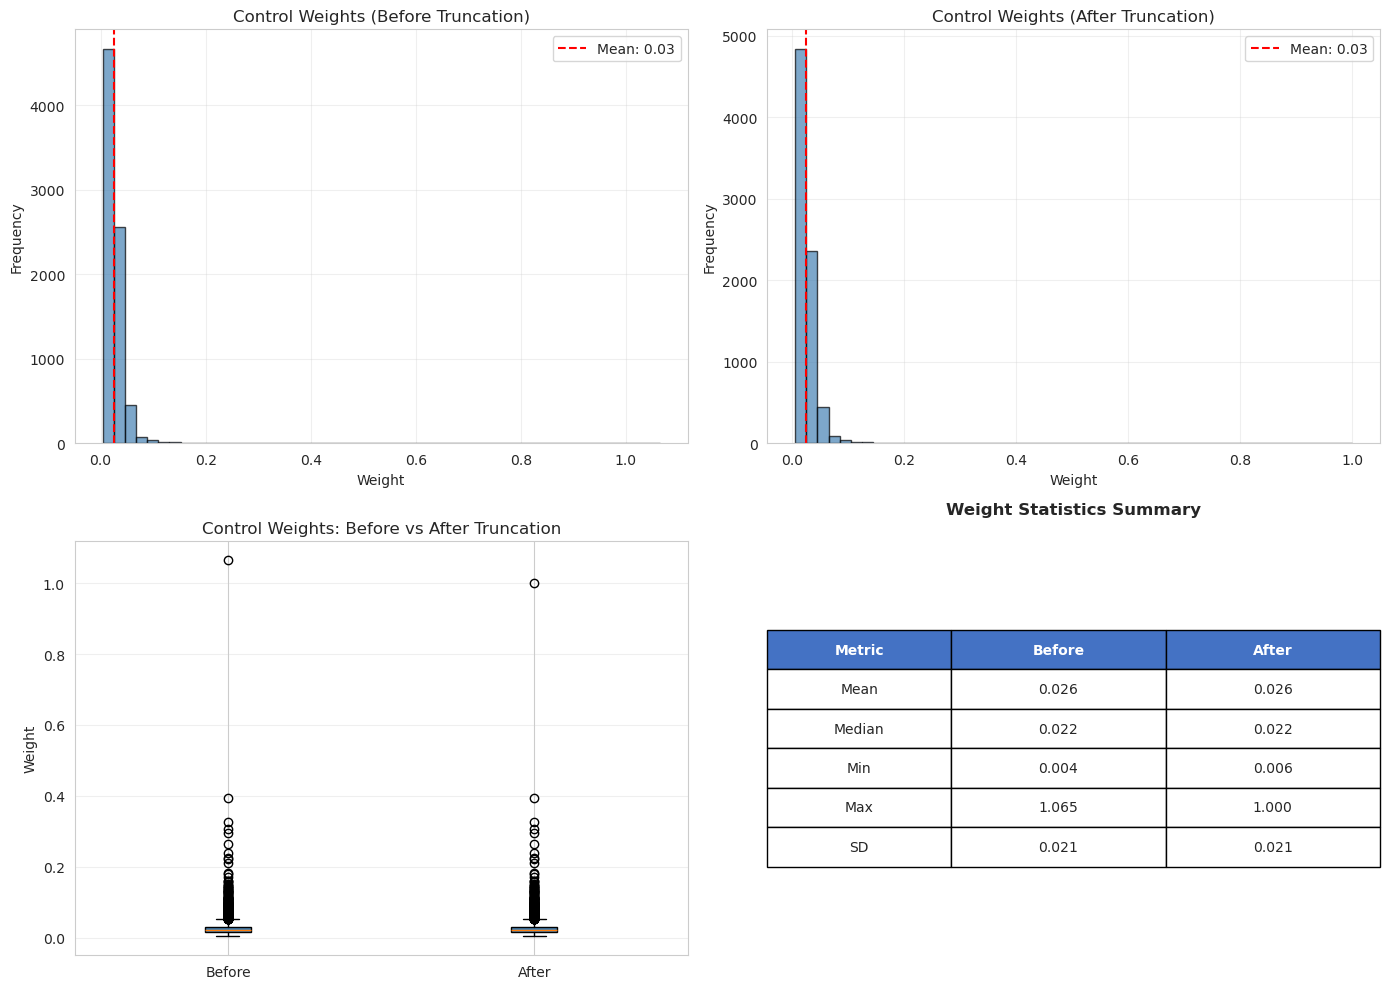

In [ ]:
results_sglt2 = run_analysis(flat, target_treatment='glp', run_bootstrap=False)

# Explorations

In [230]:
flat['age_as_of_index'].min()

18